# 0. Install

In [ ]:
pip install numpy pandas matplotlib tensorflow hmmlearn

# 1. Library

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
from scipy.stats import entropy
from hmmlearn.hmm import GaussianHMM
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, LSTM, RepeatVector, Masking

In [2]:
# 한글 폰트 설정 
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False 

# 2. Prep

### 각 제스처 폴더에서 CSV 파일 로딩
### max_seq_len: 가장 긴 시퀀스를 기준으로 패딩할 길이
### pad_sequences: keras의 유틸을 이용해 시퀀스를 동일 길이로 맞춰줌
### → LSTM 오토인코더에 넣기 위해 필수 전처리

In [3]:
# ===============================
# 1. 데이터 로딩 
# ===============================
def load_all_gesture_data(data_dir, gesture_names):
    all_sequences = []
    all_labels = []
    
    for gesture in gesture_names:
        gesture_dir = os.path.join(data_dir, gesture)
        if not os.path.isdir(gesture_dir):
            print(f"Directory not found: {gesture_dir}")
            continue
        
        file_pattern = os.path.join(gesture_dir, "*.csv")
        files = glob.glob(file_pattern)
        print(f"Loading {len(files)} files for gesture: '{gesture}'")
        
        for file in files:
            df = pd.read_csv(file)
            seq = df.values  
            all_sequences.append(seq)
            all_labels.append(gesture)
    
    return all_sequences, all_labels

# 기본 디렉토리 및 제스처 폴더 이름 리스트
data_dir = './data_project'
gesture_names = ['간호사', '갑자기', '걱정되다', '걷다', '검사', '결과', '긴가민가', '나이', '남자', '눈이멀다', '병원',
                 '보호자', '소변', '시간', '신분증', '약', '여자', '예약', '의사', '이가빠지다', '이름', '전화번호',
                 '주소', '진료', '카드', '피', '현금', '환자', '아프다', '오늘', '원하다']

# 데이터 로딩 =
sequences, labels = load_all_gesture_data(data_dir, gesture_names)
print(f"Total loaded sequences: {len(sequences)}")

# 모든 시퀀스의 최대 길이 계산 및 패딩
max_seq_len = max(seq.shape[0] for seq in sequences)
print("Max sequence length:", max_seq_len)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, dtype='float32', 
                                 padding='post', truncating='post')
print(f"Data Shape: {padded_sequences.shape}")

X_train = padded_sequences
y_train = labels
print("Using all sequences for training:", len(X_train))

Loading 30 files for gesture: '간호사'
Loading 30 files for gesture: '갑자기'
Loading 30 files for gesture: '걱정되다'
Loading 30 files for gesture: '걷다'
Loading 30 files for gesture: '검사'
Loading 30 files for gesture: '결과'
Loading 30 files for gesture: '긴가민가'
Loading 30 files for gesture: '나이'
Loading 30 files for gesture: '남자'
Loading 30 files for gesture: '눈이멀다'
Loading 30 files for gesture: '병원'
Loading 30 files for gesture: '보호자'
Loading 30 files for gesture: '소변'
Loading 30 files for gesture: '시간'
Loading 30 files for gesture: '신분증'
Loading 30 files for gesture: '약'
Loading 30 files for gesture: '여자'
Loading 30 files for gesture: '예약'
Loading 30 files for gesture: '의사'
Loading 30 files for gesture: '이가빠지다'
Loading 30 files for gesture: '이름'
Loading 30 files for gesture: '전화번호'
Loading 30 files for gesture: '주소'
Loading 30 files for gesture: '진료'
Loading 30 files for gesture: '카드'
Loading 30 files for gesture: '피'
Loading 30 files for gesture: '현금'
Loading 30 files for gesture: '환자'
Loading

# 3. Autoencoder
### LSTM 기반 Autoencoder를 사용해 시퀀스를 압축(latent representation)하고 다시 복원
### 이때 Encoder 출력은 HMM 학습의 입력으로 사용.
### 구조: Input → Masking → LSTM(encoder) → LSTM(decoder)
### 목적: latent feature 추출

In [4]:
# ===============================
# 2. LSTM Autoencoder 구축 및 학습
# ===============================
latent_dim = 256 #128, 512 등 다양하게 실험
num_features = padded_sequences.shape[2] #  한 시점에서 측정되는 특징(feature)의 수 -> 손가락 수
input_shape = (max_seq_len, num_features)
inputs = Input(shape=input_shape, name="input_sequence")
masked = Masking(mask_value=0.0, name="masking")(inputs) # 패딩된 0 값은 무시
encoded = LSTM(latent_dim, return_sequences=True, name="encoder_lstm")(masked)
decoded = LSTM(num_features, return_sequences=True, name="decoder_lstm")(encoded)
autoencoder = Model(inputs, decoded, name="lstm_autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,             # 학습 epoch 수
    batch_size=32, #16      # 배치 사이즈, 8~256, 데이터 크기, gpu환경 등 고려해서 실험
    validation_split=0.0    # 검증 데이터 사용 안 함 
)

# 인코더 모델 추출 
# 입력 → 인코더까지만 연결된 모델 생성 (잠재 시퀀스를 추출할 때 사용)
encoder_model = Model(inputs, encoded, name="encoder_model")

Model: "lstm_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_sequence (InputLayer)   │ (None, 93, 126)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 93, 126)           │               0 │ input_sequence[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 93, 126)           │               0 │ input_sequence[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any (Any)                     │ (None, 93)                │               0 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_lstm (LSTM)           │ (None, 93, 256)           │         392,192 │ masking[0][0], any[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_lstm (LSTM)           │ (None, 93, 126)           │         193,032 │ encoder_lstm[0][0],        │
│                               │                           │                 │ any[0][0]                  │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 585,224 (2.23 MB)

 Trainable params: 585,224 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0771
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0183
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0098
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0056
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0041
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0034
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0028
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0026
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0023
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0022
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0018
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0017
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0016
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0014
Epoch 15/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - lo

# 4. HMM
### 각 제스처에 대해:
### - Autoencoder의 Encoder 출력값을 latent sequence로 얻음
### - Gaussian HMM을 다양한 상태 수로 학습한 뒤, BIC를 기준으로 최적 상태 수를 선택
### → BIC: 모델의 복잡도 + 적합도 고려하는 모델 선택 지표
### 학습된 HMM은 gesture_hmms[gesture_name]에 저장

In [5]:
# ===============================
# 3. HMM 학습 (각 제스처별)
# ===============================
#  BIC 계산 함수 (다른 방법 고려해볼 수 있음 AIC?)
## BIC : 모델 복잡도(파라미터 수)를 고려해서 가장 적절한 모델을 고르기 위한 기준. 낮을수록 좋음.
def compute_bic(model, X, lengths):
    logL = model.score(X, lengths)
    n_components = model.n_components
    n_features = X.shape[1]
    n_samples = sum(lengths)
    n_params = (n_components - 1) + n_components*(n_components - 1) + 2 * n_components * n_features
    bic = -2 * logL + n_params * np.log(n_samples)
    return bic


# HMM 훈련 함수 (최적 상태 수 찾기)
def train_best_hmm_for_gesture(latent_features, lengths, state_range=(15, 20)):
    best_model = None
    best_bic = np.inf
    best_n_states = None
    for n_states in range(state_range[0], state_range[1]):
        model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=300, random_state=42) # diag vs full (diag)
        

        ## n_iter=100 100, 200 , 300 등 다양하게 실험
        ## random_state=42는 시드 고정해서 재현성 확보 위함임. 고정.

        
        try:
            model.fit(latent_features, lengths)
            bic = compute_bic(model, latent_features, lengths)
            if bic < best_bic:
                best_bic = bic
                best_model = model
                best_n_states = n_states
        except Exception as e:
            print(f"n_states={n_states}에서 학습 실패: {e}")
    return best_model, best_n_states, best_bic

gesture_hmms = {}
for gesture in gesture_names:
    indices = [i for i, lab in enumerate(y_train) if lab == gesture]
    if len(indices) == 0:
        print(f"학습 샘플이 부족합니다: {gesture}")
        continue
    
    features_list = []
    lengths = []
    for i in indices:
        seq = X_train[i]  # (seq_length, num_features)
        latent_seq = encoder_model.predict(seq[np.newaxis, ...])[0]
        features_list.append(latent_seq)
        lengths.append(latent_seq.shape[0])

    # HMM 학습 및 저장
    concatenated_features = np.concatenate(features_list, axis=0)
    best_model, best_n_states, best_bic = train_best_hmm_for_gesture(concatenated_features, lengths, state_range=(15, 20)) #16
    ## 여기서 state_range= 를 실험하면서 설정해줘야하는데, 이건 HMM의 은닉 상태(hidden state) 개수를 의미
    ## 너무 작으면 제스처를 제대로 표현하지 못하고, 너무 크면 오버피팅 또는 학습 불안정 발생함
    ## 5~10, 15~20, 20~30 다양하게 실험하기
    
    gesture_hmms[gesture] = best_model
    print(f"Gesture '{gesture}': 최적 상태 수 = {best_n_states}, BIC = {best_bic}")

print("모든 제스처 HMM 학습 완료.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

Model is not converging.  Current: 1658578.525681352 is not greater than 1658578.838852685. Delta is -0.3131713329348713
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 1672522.378136563. Delta is -inf


n_states=18에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 1695086.8337105904. Delta is -inf


n_states=19에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '간호사': 최적 상태 수 = 17, BIC = -3318728.8244629772
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2225817.975773272. Delta is -inf


n_states=16에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2239300.2800554037. Delta is -inf


n_states=17에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2225060.9645972187. Delta is -inf


n_states=18에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2303468.2408263204. Delta is -inf


n_states=19에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '갑자기': 최적 상태 수 = 15, BIC = -4436185.830588796
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━

Model is not converging.  Current: 2057398.6679552447 is not greater than 2057398.6686997337. Delta is -0.0007444890215992928
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have ze

n_states=16에서 학습 실패: startprob_ must sum to 1 (got nan)


Model is not converging.  Current: 2073397.682022171 is not greater than 2073397.728323731. Delta is -0.04630156001076102
Model is not converging.  Current: 2091564.6728010252 is not greater than 2091564.7563043584. Delta is -0.08350333315320313
Model is not converging.  Current: 2090129.8589465627 is not greater than 2090130.8051706753. Delta is -0.9462241125293076


Gesture '걱정되다': 최적 상태 수 = 18, BIC = -4107448.712106161
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

Model is not converging.  Current: 1933046.0216974036 is not greater than 1933046.164281971. Delta is -0.1425845674239099
Model is not converging.  Current: 1958082.2985541876 is not greater than 1958102.7474111503. Delta is -20.4488569626119
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2007632.1801120327. Delta is -inf


n_states=17에서 학습 실패: startprob_ must sum to 1 (got nan)


Model is not converging.  Current: 2032367.5485044587 is not greater than 2032368.0166124091. Delta is -0.4681079504080117


Gesture '걷다': 최적 상태 수 = 19, BIC = -3984694.0065555717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/s

Model is not converging.  Current: 2093940.028118327 is not greater than 2093941.8950453566. Delta is -1.8669270295649767
Model is not converging.  Current: 2142321.9386746087 is not greater than 2142322.1174698435. Delta is -0.17879523476585746
Model is not converging.  Current: 2124341.1122886958 is not greater than 2124344.0615120535. Delta is -2.949223357718438
Model is not converging.  Current: 2172422.976944626 is not greater than 2172428.5887057963. Delta is -5.611761170439422


Gesture '검사': 최적 상태 수 = 19, BIC = -4264807.895605955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

Model is not converging.  Current: 1832865.5004099372 is not greater than 1832865.5005069955. Delta is -9.70582477748394e-05


Gesture '결과': 최적 상태 수 = 19, BIC = -3685157.634408864
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

Model is not converging.  Current: 2381477.1841527782 is not greater than 2381482.822837773. Delta is -5.638684994541109
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2353115.77479138. Delta is -inf


n_states=17에서 학습 실패: startprob_ must sum to 1 (got nan)


Model is not converging.  Current: 2400851.089221292 is not greater than 2400922.4161867867. Delta is -71.32696549454704
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2391398.9928858005. Delta is -inf


n_states=19에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '긴가민가': 최적 상태 수 = 18, BIC = -4726008.649189381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2086325.878475622. Delta is -inf


n_states=15에서 학습 실패: startprob_ must sum to 1 (got nan)


Model is not converging.  Current: 2117525.3612970007 is not greater than 2117529.25832269. Delta is -3.897025689482689
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2096202.4302402628. Delta is -inf


n_states=18에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '나이': 최적 상태 수 = 19, BIC = -4279835.778562941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━

Model is not converging.  Current: 1943138.5256130234 is not greater than 1943138.761256163. Delta is -0.23564313957467675
Model is not converging.  Current: 1964150.925570298 is not greater than 1964162.0642495651. Delta is -11.138679267140105


Gesture '남자': 최적 상태 수 = 19, BIC = -3929845.3255153145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/s

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2225587.024471182. Delta is -inf


n_states=15에서 학습 실패: startprob_ must sum to 1 (got nan)


Model is not converging.  Current: 2287981.7416925123 is not greater than 2288006.4525467465. Delta is -24.710854234173894
Model is not converging.  Current: 2308356.8437896054 is not greater than 2308378.7471144525. Delta is -21.903324847109616
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2265685.3167370427. Delta is -inf


n_states=19에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '눈이멀다': 최적 상태 수 = 18, BIC = -4540944.974028617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━

Model is not converging.  Current: 1690650.5016460887 is not greater than 1690651.2140443316. Delta is -0.7123982429038733
Model is not converging.  Current: 1725566.9061827462 is not greater than 1725568.15193524. Delta is -1.2457524938508868
Model is not converging.  Current: 1738945.0454107 is not greater than 1738945.0846129262. Delta is -0.03920222632586956
Model is not converging.  Current: 1765827.8967478008 is not greater than 1765829.4548247939. Delta is -1.5580769930966198
Model is not converging.  Current: 1768604.8409538295 is not greater than 1768611.8939788425. Delta is -7.053025013068691


Gesture '병원': 최적 상태 수 = 19, BIC = -3457169.752110368
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

Model is not converging.  Current: 1508454.3248485995 is not greater than 1508456.0917805226. Delta is -1.7669319231063128
Model is not converging.  Current: 1547761.0665764124 is not greater than 1547761.0856237158. Delta is -0.019047303358092904
Model is not converging.  Current: 1555717.8103365728 is not greater than 1555718.1870560076. Delta is -0.37671943474560976


Gesture '보호자': 최적 상태 수 = 19, BIC = -3096714.537710826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/s

Model is not converging.  Current: 2058990.093809936 is not greater than 2058991.7449102912. Delta is -1.6511003552004695
Model is not converging.  Current: 2070138.072137463 is not greater than 2070138.3631403942. Delta is -0.29100293130613863
Model is not converging.  Current: 2091633.5286476698 is not greater than 2091634.1075722498. Delta is -0.5789245800115168


Gesture '소변': 최적 상태 수 = 18, BIC = -4104236.964312194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/st

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2203795.6739592287. Delta is -inf


n_states=17에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2119386.648998813. Delta is -inf


n_states=18에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2213153.4000550527. Delta is -inf


n_states=19에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '신분증': 최적 상태 수 = 15, BIC = -4333112.224705065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━

Model is not converging.  Current: 1997904.190149552 is not greater than 1997905.4324895474. Delta is -1.2423399954568595
Model is not converging.  Current: 2026566.8473207084 is not greater than 2026566.9043735228. Delta is -0.05705281440168619
Model is not converging.  Current: 2053534.997862735 is not greater than 2053536.0525064052. Delta is -1.0546436700969934
Model is not converging.  Current: 2048799.0523224117 is not greater than 2048799.2480927892. Delta is -0.19577037752605975
Model is not converging.  Current: 2076398.4635678092 is not greater than 2076398.5469602824. Delta is -0.08339247317053378


Gesture '여자': 최적 상태 수 = 19, BIC = -4072760.540706798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/st

Model is not converging.  Current: 1842138.3835033441 is not greater than 1842142.2143019694. Delta is -3.830798625247553
Model is not converging.  Current: 1823356.8300966993 is not greater than 1823366.4106579286. Delta is -9.580561229260638
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 1898219.006626905. Delta is -inf


n_states=19에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '예약': 최적 상태 수 = 18, BIC = -3773908.8909081044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━

Model is not converging.  Current: 2015472.5597491658 is not greater than 2015479.7260700667. Delta is -7.166320900898427
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 1992143.5272902627. Delta is -inf


n_states=17에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 1956515.0811655985. Delta is -inf


n_states=19에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '의사': 최적 상태 수 = 18, BIC = -4074196.418113823
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━

C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2334061.6540873414. Delta is -inf


n_states=15에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2348410.745966859. Delta is -inf


n_states=17에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from

n_states=18에서 학습 실패: startprob_ must sum to 1 (got nan)


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2343369.9470061776. Delta is -inf


n_states=19에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '이가빠지다': 최적 상태 수 = 16, BIC = -4700563.573616762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

Model is not converging.  Current: 2164381.299636443 is not greater than 2164381.336248525. Delta is -0.03661208180710673
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 2132421.2156404494. Delta is -inf


n_states=18에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '이름': 최적 상태 수 = 19, BIC = -4268715.108418092
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━

Model is not converging.  Current: 1921389.5727515044 is not greater than 1921389.5727662733. Delta is -1.4768913388252258e-05
Model is not converging.  Current: 1910866.1001470967 is not greater than 1910866.3792651535. Delta is -0.27911805687472224
Model is not converging.  Current: 2002756.4708975558 is not greater than 2002758.4528839926. Delta is -1.981986436760053
Model is not converging.  Current: 2008231.6639377084 is not greater than 2008231.7009894138. Delta is -0.03705170541070402


Gesture '전화번호': 최적 상태 수 = 19, BIC = -3936427.177595856
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/

Model is not converging.  Current: 1675689.551935938 is not greater than 1675691.2862324305. Delta is -1.7342964925337583


Gesture '주소': 최적 상태 수 = 19, BIC = -3271342.919622341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/st

Model is not converging.  Current: 1790267.093767802 is not greater than 1790272.8403513064. Delta is -5.746583504369482
Model is not converging.  Current: 1809808.1701522707 is not greater than 1809816.6950534526. Delta is -8.524901181925088


Gesture '진료': 최적 상태 수 = 19, BIC = -3609751.5332261007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/s

Model is not converging.  Current: 1963926.953229073 is not greater than 1963927.011457738. Delta is -0.05822866503149271
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 1952997.453064876. Delta is -inf


n_states=18에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '카드': 최적 상태 수 = 19, BIC = -3992330.3740949994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━

Model is not converging.  Current: 1416154.348418796 is not greater than 1416155.9213754467. Delta is -1.5729566507507116
Model is not converging.  Current: 1429500.5630757145 is not greater than 1429500.5631196215. Delta is -4.390696994960308e-05
Model is not converging.  Current: 1444444.5993622774 is not greater than 1444444.5994867724. Delta is -0.0001244950108230114


Gesture '피': 최적 상태 수 = 19, BIC = -2908865.3586439393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

Model is not converging.  Current: 1946541.3809531198 is not greater than 1946542.1134790787. Delta is -0.7325259589124471
C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Model is not converging.  Current: -inf is not greater than 1831858.7665959606. Delta is -inf


n_states=18에서 학습 실패: startprob_ must sum to 1 (got nan)
Gesture '현금': 최적 상태 수 = 19, BIC = -3917783.1246434967
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━

Model is not converging.  Current: 1787388.9524697706 is not greater than 1787388.952686855. Delta is -0.00021708454005420208


Gesture '환자': 최적 상태 수 = 19, BIC = -3641215.5138875716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/s

Model is not converging.  Current: 1751159.5581189273 is not greater than 1751159.5774182086. Delta is -0.019299281295388937
Model is not converging.  Current: 1789517.207402202 is not greater than 1789517.4260222889. Delta is -0.21862008678726852
Model is not converging.  Current: 1823776.1270169003 is not greater than 1823777.2007851542. Delta is -1.073768253903836
Model is not converging.  Current: 1838657.5388318244 is not greater than 1838657.711327525. Delta is -0.17249570065177977


Gesture '아프다': 최적 상태 수 = 19, BIC = -3597278.665998019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/s

Model is not converging.  Current: 1424439.4858873559 is not greater than 1424439.4861418738. Delta is -0.00025451788678765297
Model is not converging.  Current: 1439050.3624392864 is not greater than 1439051.5078365537. Delta is -1.1453972673043609
Model is not converging.  Current: 1497380.67928927 is not greater than 1497383.2244608602. Delta is -2.545171590289101


Gesture '오늘': 최적 상태 수 = 19, BIC = -2914724.9332464347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/s

Model is not converging.  Current: 1979959.6690215752 is not greater than 1979978.318450623. Delta is -18.649429047713056
Model is not converging.  Current: 2001235.4482662075 is not greater than 2001240.5887166741. Delta is -5.140450466657057


Gesture '원하다': 최적 상태 수 = 19, BIC = -3922432.038309324
모든 제스처 HMM 학습 완료.


# 5. Threshold Model(ergodic model) 

In [6]:
# ===============================
# 4. 임계치 모델 및 제스처 적출 네트워크
# ===============================

## 모든 제스처의 상태들을 하나의 ergodic HMM으로 묶고, ST(시작)과 FT(종료) 상태를 추가하여 Threshold 모델로 활용
def build_ergodic_threshold_model_with_null(gesture_hmms):
    means_list = []
    covars_list = []
    self_trans_list = []
    state_labels = []
    
    # 개별 제스처 모델에서 상태, 공분산, 자체전이 확률 추출
    for gesture, model in gesture_hmms.items():
        n_states = model.means_.shape[0]
        means_list.append(model.means_)
        covars = model.covars_
        if covars.ndim == 3:
            diag_covars = np.array([np.diag(cov) for cov in covars])
            covars = diag_covars
        covars_list.append(covars)
        self_trans_list.append(np.diag(model.transmat_))
        state_labels.extend([gesture] * n_states)
    
    all_means = np.vstack(means_list)
    all_covars = np.vstack(covars_list)
    all_self_trans = np.concatenate(self_trans_list)
    N = all_means.shape[0]
    n_features = all_means.shape[1]
    
    # ST와 FT는 NULL 상태이므로 여기서는 자체전이 확률을 0으로 설정(즉, 입력 처리 없이 즉시 타 상태로 전이)
    st_mean = np.zeros((1, n_features))
    st_covar = np.ones((1, n_features))
    st_self = np.array([0.0])
    ft_mean = np.zeros((1, n_features))
    ft_covar = np.ones((1, n_features))
    ft_self = np.array([0.0])
    
    # 제스처 상태와 함께 ST, FT 상태 추가
    means = np.vstack([st_mean, all_means, ft_mean])
    covars = np.vstack([st_covar, all_covars, ft_covar])
    # 각 상태의 자기전이 확률: 제스처 모델은 원래 확률을 사용하고, ST와 FT는 0.0으로 설정
    self_trans = np.concatenate([st_self, all_self_trans, ft_self])
    total_states = N + 2  # ST + 제스처 상태들 + FT

    # 모든 상태에 대해, 자기 자신 외의 모든 상태로 균등 분포하도록 전이 확률을 할당
    transmat = np.zeros((total_states, total_states))
    for i in range(total_states):
        a_i = self_trans[i]
        for j in range(total_states):
            if i == j:
                transmat[i, j] = a_i
            else:
                transmat[i, j] = (1 - a_i) / (total_states - 1)
    
    # ergodic 모델 구성
    ergodic_model = GaussianHMM(n_components=total_states, covariance_type="diag", init_params="") # covariance_type = diag or full
    startprob = np.zeros(total_states)
    # 시작 상태(ST)는 반드시 1로 설정 (출발 상태)
    startprob[0] = 1.0
    ergodic_model.startprob_ = startprob
    ergodic_model.transmat_ = transmat
    ergodic_model.means_ = means
    ergodic_model.covars_ = covars
    ergodic_model.n_features = n_features
    new_state_labels = ["ST"] + state_labels + ["FT"]
    
    return ergodic_model, new_state_labels


#하나로 결합할 때 필요한 각 상태의 평균, 공분산, 자기전이 확률, 레이블들을 리스트 형태로 수집하는 함수.
def extract_individual_states(gesture_hmms):
    means_list = []
    covars_list = []
    self_trans_list = []
    labels_list = []
    
    for gesture, model in gesture_hmms.items():
        n_states = model.means_.shape[0]
        means_list.append(model.means_)
        covars = model.covars_
        if covars.ndim == 3:
            covars = np.array([np.diag(cov) for cov in covars])
        covars_list.append(covars)
        self_trans_list.append(np.diag(model.transmat_))
        labels_list.extend([gesture] * n_states)
    
    individual_means = np.vstack(means_list)
    individual_covars = np.vstack(covars_list)
    individual_self = np.concatenate(self_trans_list)
    
    return individual_means, individual_covars, individual_self, labels_list

# ergodic 모델 구성
ergodic_model, state_labels = build_ergodic_threshold_model_with_null(gesture_hmms)

# 슬라이딩 윈도우

In [7]:
def filter_short_intervals(detected_intervals, min_length=5):
    """
    (start, end, label) 구간들 중에서,
    - 길이(end - start)가 min_length 미만인 것은 제거
    """
    filtered = []
    for (s, e, lab) in detected_intervals:
        if (e - s) >= min_length:
            filtered.append((s, e, lab))
    return filtered

def merge_gesture_intervals(detected_intervals, min_merge_gap=0):
    """
    (start, end, label) 리스트에서,
    - 라벨이 동일하고 구간이 겹치거나 (끝 지점 >= 다음 시작 지점)
      혹은 두 구간 사이 간격이 min_merge_gap 이하인 경우 병합
    - 정렬 후 순회하며 병합
    """
    if not detected_intervals:
        return []

    # 시작 프레임 기준으로 정렬
    sorted_intervals = sorted(detected_intervals, key=lambda x: x[0])
    merged = []

    current_start, current_end, current_label = sorted_intervals[0]

    for i in range(1, len(sorted_intervals)):
        s, e, lab = sorted_intervals[i]

        # 조건: 라벨 동일 + (s <= current_end + min_merge_gap) 이면 병합
        if (lab == current_label) and (s <= current_end + min_merge_gap):
            current_end = max(current_end, e)  # 구간 확장
        else:
            merged.append((current_start, current_end, current_label))
            current_start, current_end, current_label = s, e, lab

    # 마지막 구간 처리
    merged.append((current_start, current_end, current_label))
    return merged

def sliding_window_gesture_detection_with_plot(
    continuous_sequence, 
    encoder_model,
    gesture_hmms, 
    final_model,
    window_size=20, 
    step=2, 
    threshold_diff=3.0,
    min_merge_gap=5,
    min_interval_length=5
):
    """

    파라미터:
    - continuous_sequence: shape (T, num_features)
    - encoder_model: 오토인코더 인코더 (latent feature 추출)
    - gesture_hmms: {제스처이름: HMM모델}
    - final_model: Threshold(Ergodic) 모델 (GaussianHMM)
    - window_size, step: 슬라이딩 윈도우 크기, 이동 간격
    - threshold_diff: (제스처 점수 - Final 점수)가 이 값 이상이면 해당 제스처로 판단
    - min_merge_gap: 병합 시 구간 사이 허용하는 최대 gap(프레임 수)
    - min_interval_length: 필터 시 제거할 최소 길이(프레임 수)

    """
    T = continuous_sequence.shape[0]
    gesture_names = list(gesture_hmms.keys())
    n_gestures = len(gesture_names)

    if T < window_size:
        print("연속 데이터 길이가 윈도우 길이보다 짧습니다. 탐지할 구간이 없습니다.")
        return []

    n_windows = (T - window_size) // step + 1

    # 슬라이딩 윈도우 분류
    detected_intervals = []
    gesture_ll = np.zeros((n_windows, n_gestures))  # 각 윈도우에서의 제스처 
    final_ll = np.zeros(n_windows)                  # 각 윈도우에서의 Final 모델 
    window_indices = np.zeros(n_windows, dtype=int)  # 그래프 X축(윈도우 시작점)

    for w in range(n_windows):
        start_idx = w * step
        end_idx = start_idx + window_size
        window_data = continuous_sequence[start_idx:end_idx, :]

        # 오토인코더 인코더로 latent feature 추출
        latent_seq = encoder_model.predict(window_data[np.newaxis, ...])[0]
        seq_len = latent_seq.shape[0]
        lengths = [seq_len]

        # Threshold 모델 로그 가능도
        f_ll = final_model.score(latent_seq, lengths)
        final_ll[w] = f_ll

        # 각 제스처 모델 로그 가능도
        max_diff = -np.inf
        best_gesture = None
        for g, gesture_name in enumerate(gesture_names):
            g_ll = gesture_hmms[gesture_name].score(latent_seq, lengths)
            gesture_ll[w, g] = g_ll

            diff = g_ll - f_ll
            if diff > max_diff:
                max_diff = diff
                best_gesture = gesture_name

        # threshold_diff 이상이면 해당 제스처로 판단
        if max_diff >= threshold_diff:
            detected_intervals.append((start_idx, end_idx, best_gesture))

        # 그래프 x축에 쓸 윈도우 시작점
        window_indices[w] = start_idx

    # 로그 가능도 시각화
    plt.figure(figsize=(12, 6))
    
    # Threshold 모델 
    plt.plot(window_indices, final_ll,
             label="Threshold Model",
             color="black", linewidth=2, linestyle="--")
    
    # 각 제스처 모델 
    colors = plt.cm.rainbow(np.linspace(0, 1, n_gestures))
    for g, gesture_name in enumerate(gesture_names):
        plt.plot(window_indices, gesture_ll[:, g],
                 label=f"{gesture_name}",
                 color=colors[g])

    plt.title("Gesture Recognition")
    plt.xlabel("Time")
    plt.ylabel("Likelihood")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # 병합 + 너무 짧은 구간 제거
    merged_intervals = merge_gesture_intervals(detected_intervals, min_merge_gap=min_merge_gap)
    final_intervals = filter_short_intervals(merged_intervals, min_length=min_interval_length)

    return final_intervals

# 7. Result

In [8]:
# 0인 구간 거거
def trim_zero_padding(sequence):
    non_zero_rows = np.any(sequence != 0, axis=1)
    return sequence[non_zero_rows] 

Processing file: data_project/전화번호\전화번호 (1).csv
  → Loaded continuous data shape: (33, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


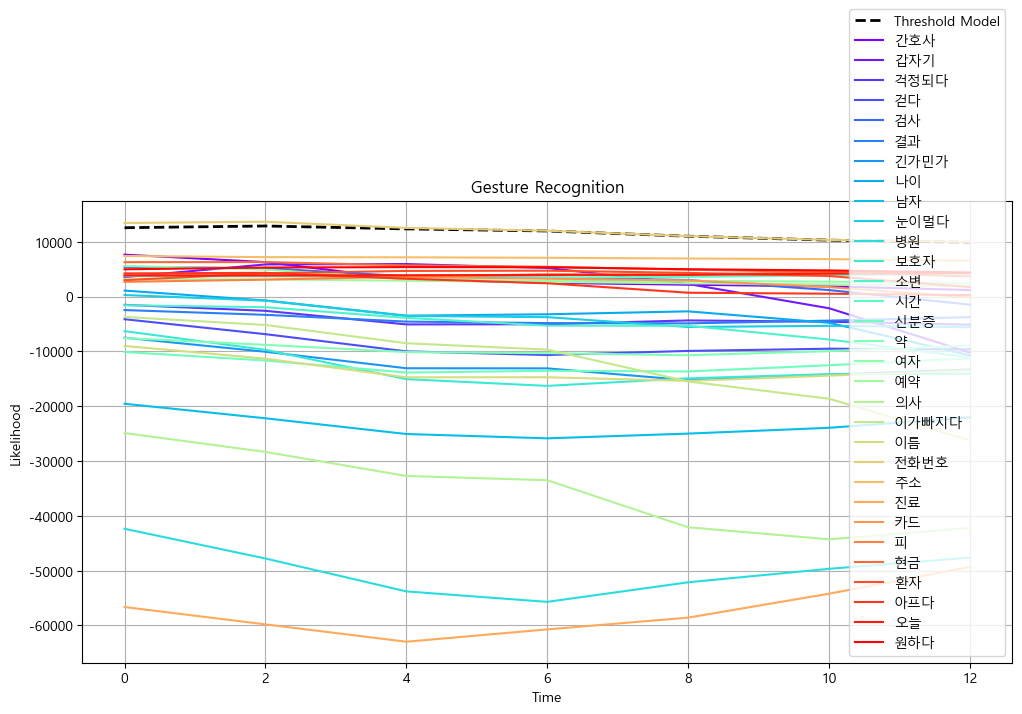

[data_project/전화번호\전화번호 (1).csv] 식별된 구간:
  -    0 ~   32 : 전화번호
Processing file: data_project/전화번호\전화번호 (10).csv
  → Loaded continuous data shape: (42, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


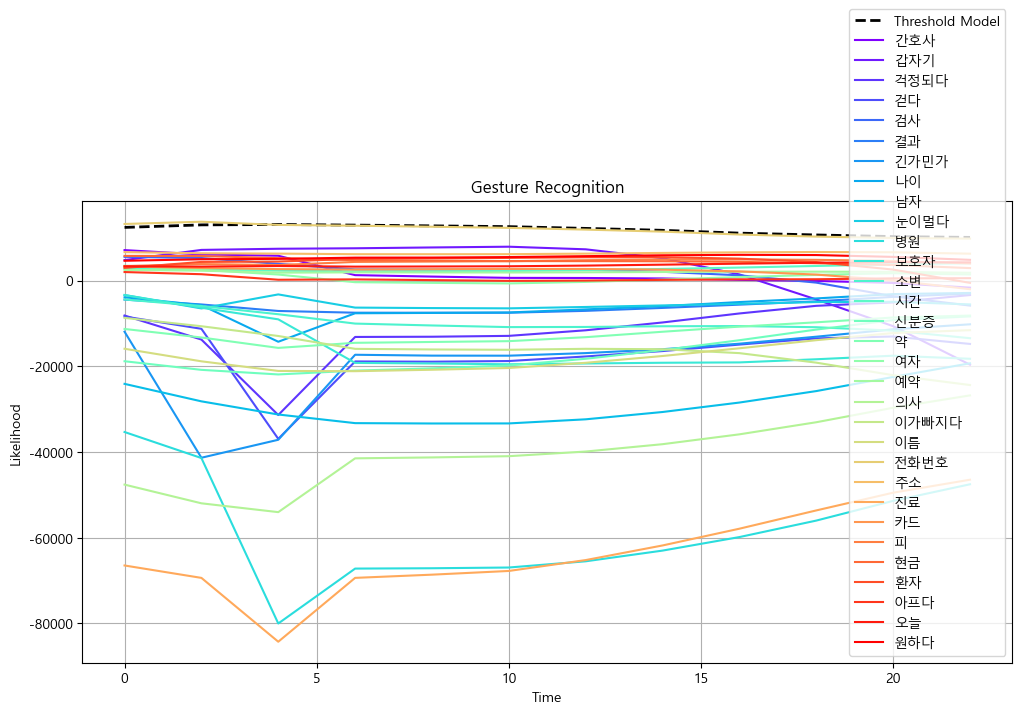

[data_project/전화번호\전화번호 (10).csv] 식별된 구간:
  -    0 ~   22 : 전화번호
Processing file: data_project/전화번호\전화번호 (11).csv
  → Loaded continuous data shape: (37, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


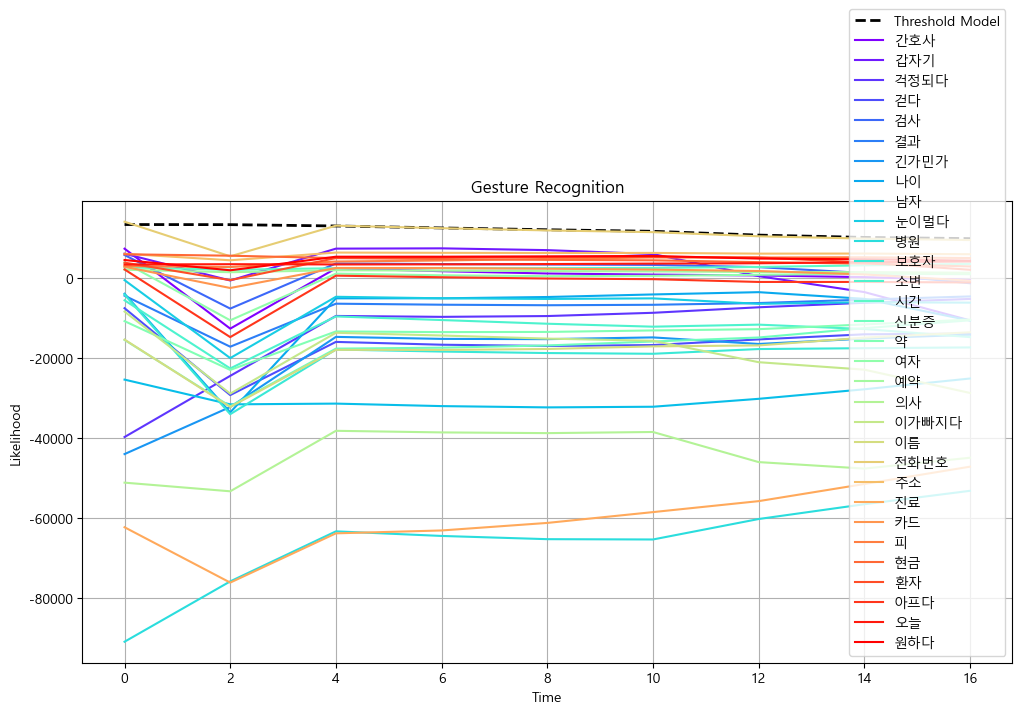

[data_project/전화번호\전화번호 (11).csv] 식별된 구간:
  -    0 ~   24 : 전화번호
Processing file: data_project/전화번호\전화번호 (12).csv
  → Loaded continuous data shape: (39, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


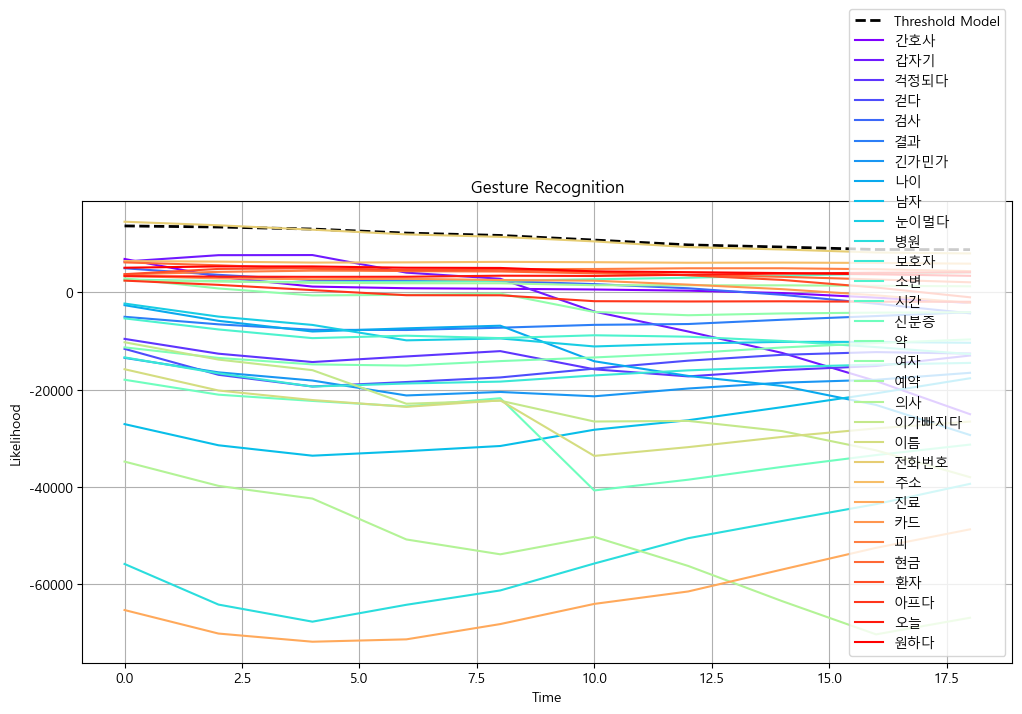

[data_project/전화번호\전화번호 (12).csv] 식별된 구간:
  -    0 ~   22 : 전화번호
Processing file: data_project/전화번호\전화번호 (13).csv
  → Loaded continuous data shape: (50, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


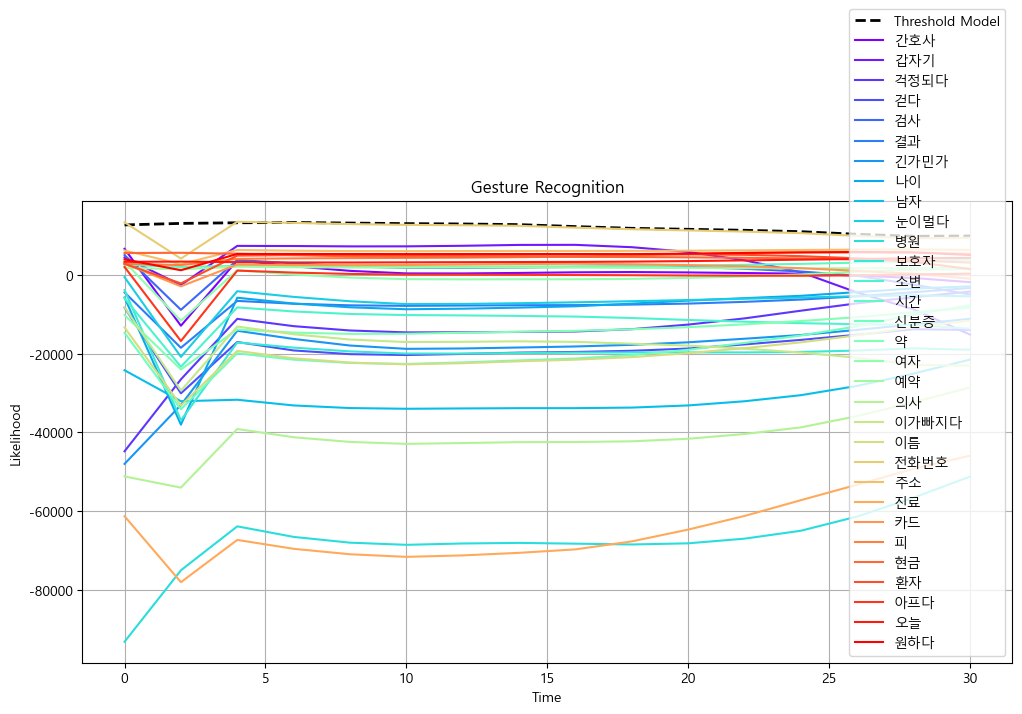

[data_project/전화번호\전화번호 (13).csv] 식별된 구간:
  -    0 ~   24 : 전화번호
Processing file: data_project/전화번호\전화번호 (14).csv
  → Loaded continuous data shape: (39, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


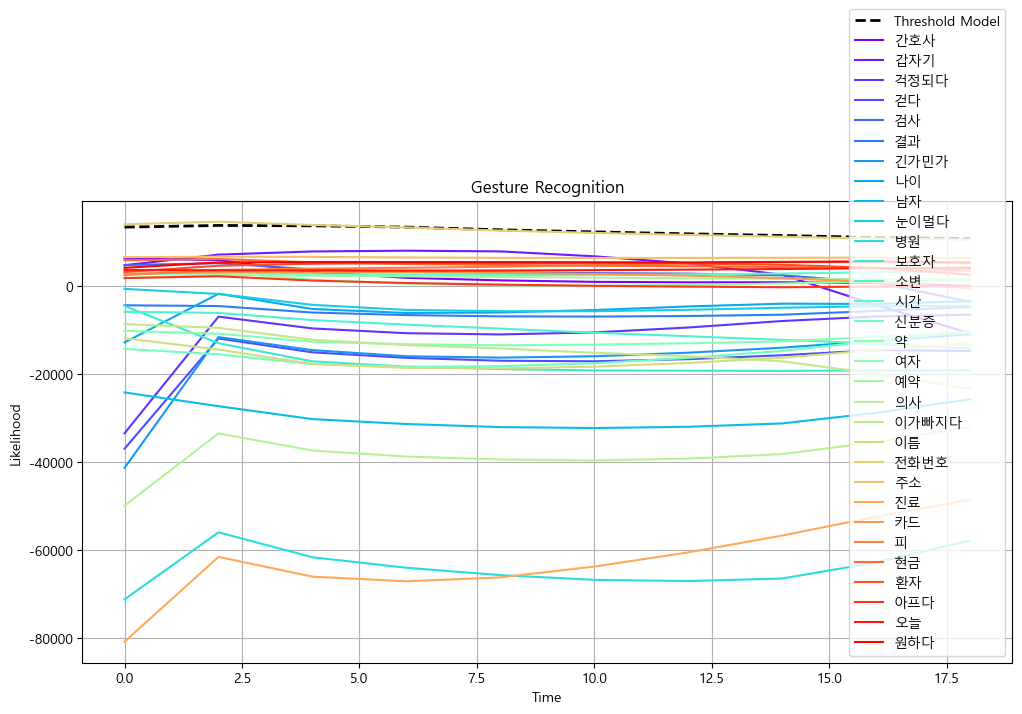

[data_project/전화번호\전화번호 (14).csv] 식별된 구간:
  -    0 ~   24 : 전화번호
Processing file: data_project/전화번호\전화번호 (15).csv
  → Loaded continuous data shape: (36, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


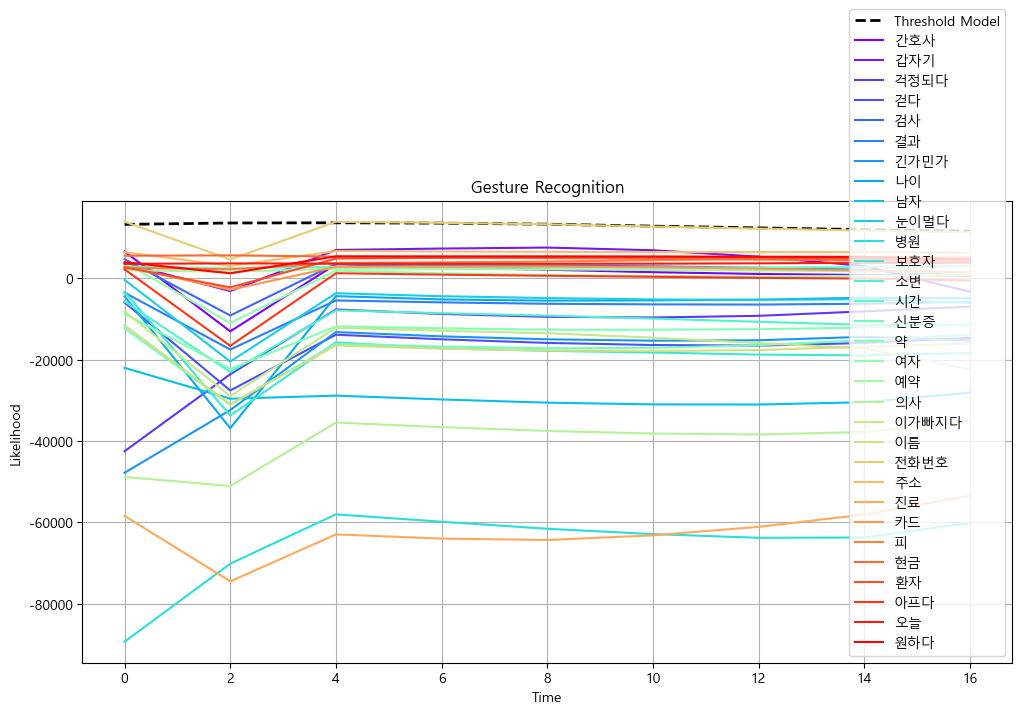

[data_project/전화번호\전화번호 (15).csv] 식별된 구간:
  -    0 ~   26 : 전화번호
Processing file: data_project/전화번호\전화번호 (16).csv
  → Loaded continuous data shape: (44, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


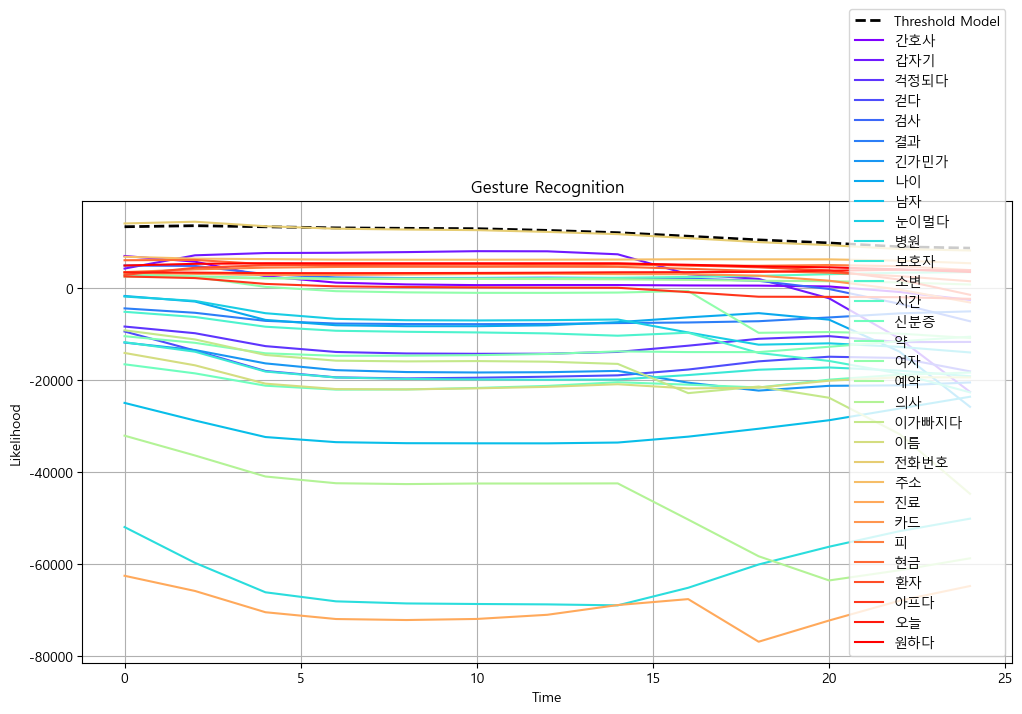

[data_project/전화번호\전화번호 (16).csv] 식별된 구간:
  -    0 ~   24 : 전화번호
Processing file: data_project/전화번호\전화번호 (17).csv
  → Loaded continuous data shape: (43, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


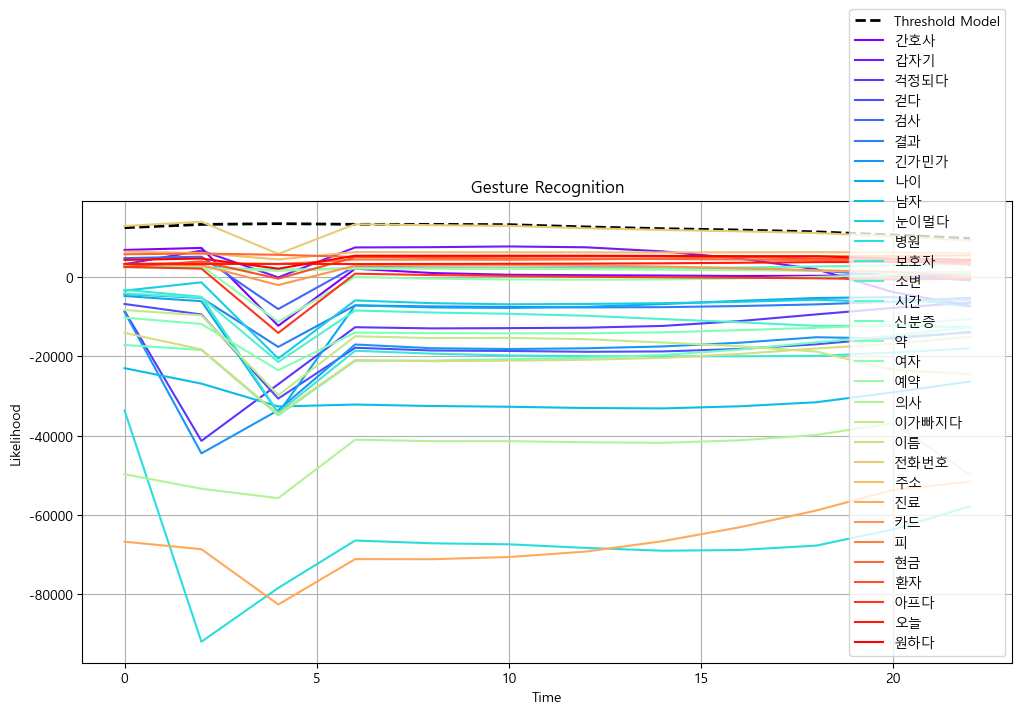

[data_project/전화번호\전화번호 (17).csv] 식별된 구간:
  -    0 ~   26 : 전화번호
Processing file: data_project/전화번호\전화번호 (18).csv
  → Loaded continuous data shape: (42, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


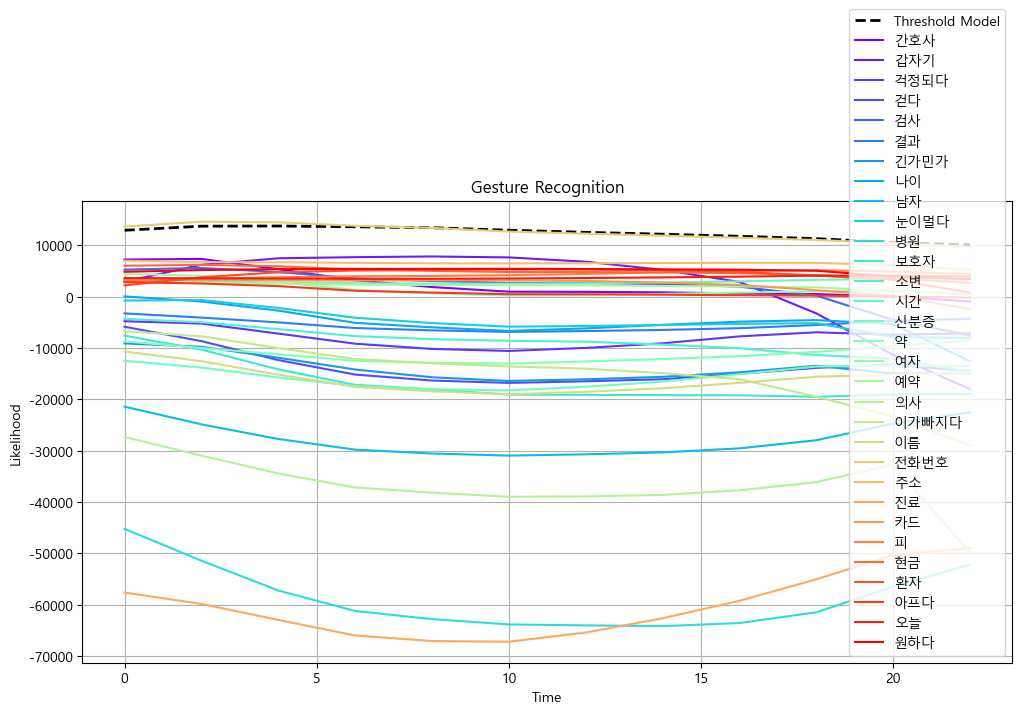

[data_project/전화번호\전화번호 (18).csv] 식별된 구간:
  -    0 ~   26 : 전화번호
Processing file: data_project/전화번호\전화번호 (19).csv
  → Loaded continuous data shape: (39, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


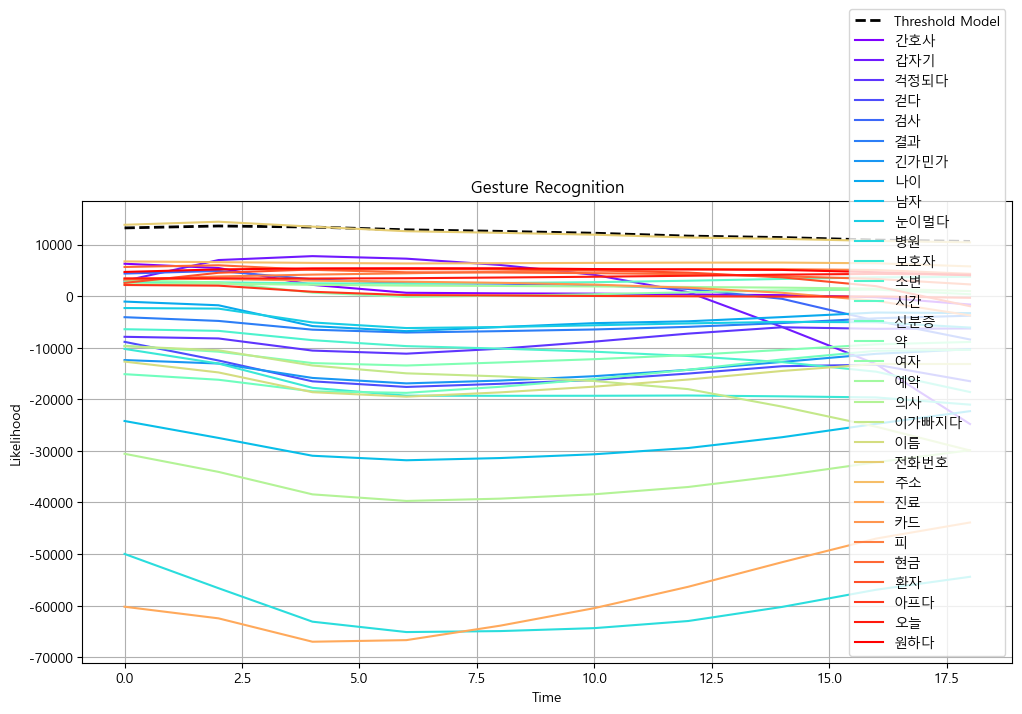

[data_project/전화번호\전화번호 (19).csv] 식별된 구간:
  -    0 ~   24 : 전화번호
Processing file: data_project/전화번호\전화번호 (2).csv
  → Loaded continuous data shape: (1, 126)
연속 데이터 길이가 윈도우 길이보다 짧습니다. 탐지할 구간이 없습니다.
[data_project/전화번호\전화번호 (2).csv] 식별된 구간:
Processing file: data_project/전화번호\전화번호 (20).csv
  → Loaded continuous data shape: (39, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


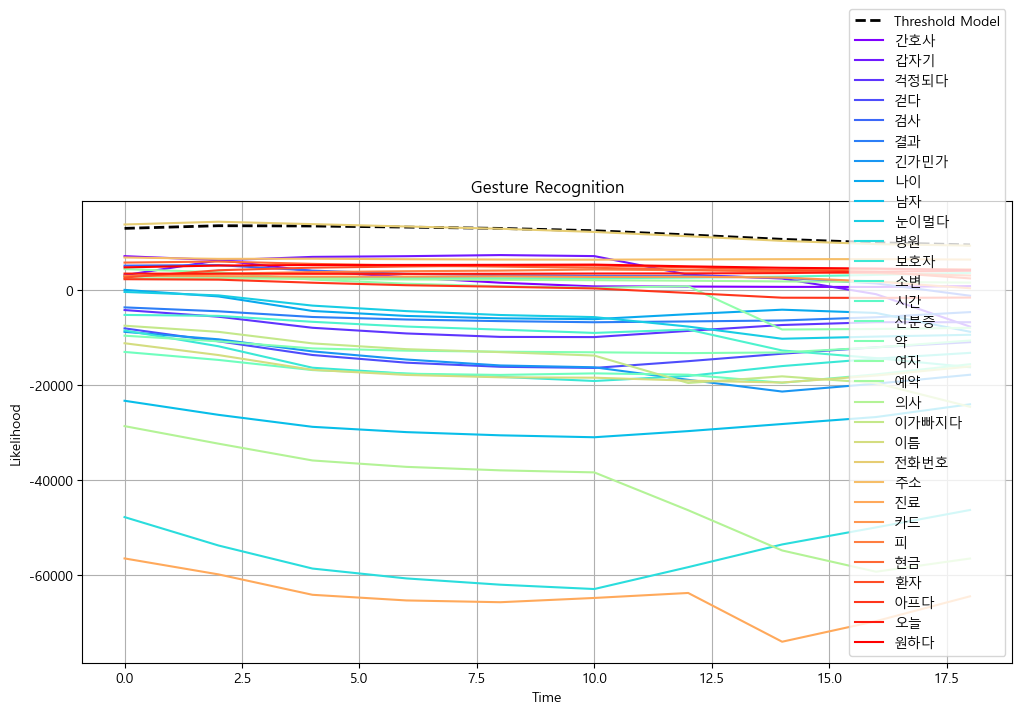

[data_project/전화번호\전화번호 (20).csv] 식별된 구간:
  -    0 ~   26 : 전화번호
Processing file: data_project/전화번호\전화번호 (21).csv
  → Loaded continuous data shape: (34, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


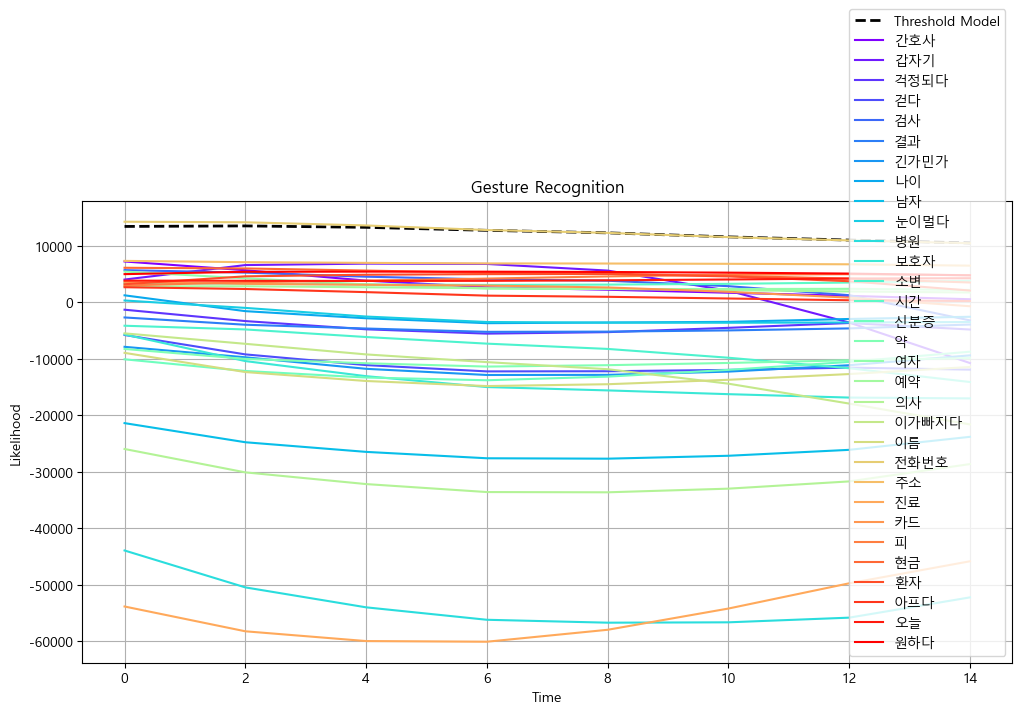

[data_project/전화번호\전화번호 (21).csv] 식별된 구간:
  -    0 ~   26 : 전화번호
Processing file: data_project/전화번호\전화번호 (22).csv
  → Loaded continuous data shape: (34, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


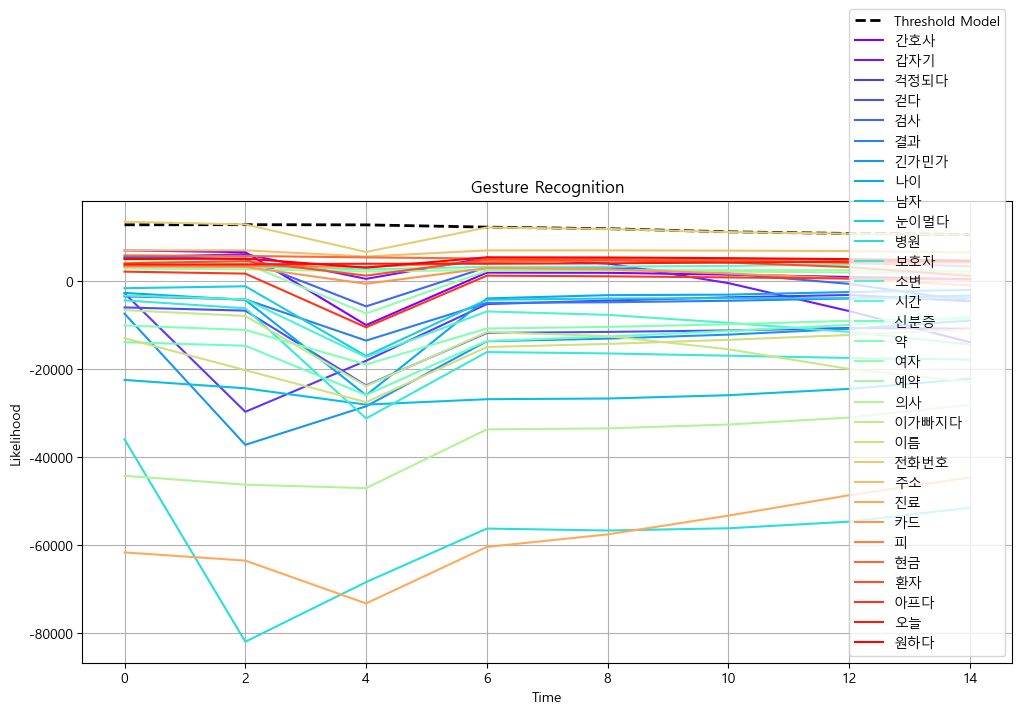

[data_project/전화번호\전화번호 (22).csv] 식별된 구간:
  -    0 ~   22 : 전화번호
Processing file: data_project/전화번호\전화번호 (23).csv
  → Loaded continuous data shape: (33, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


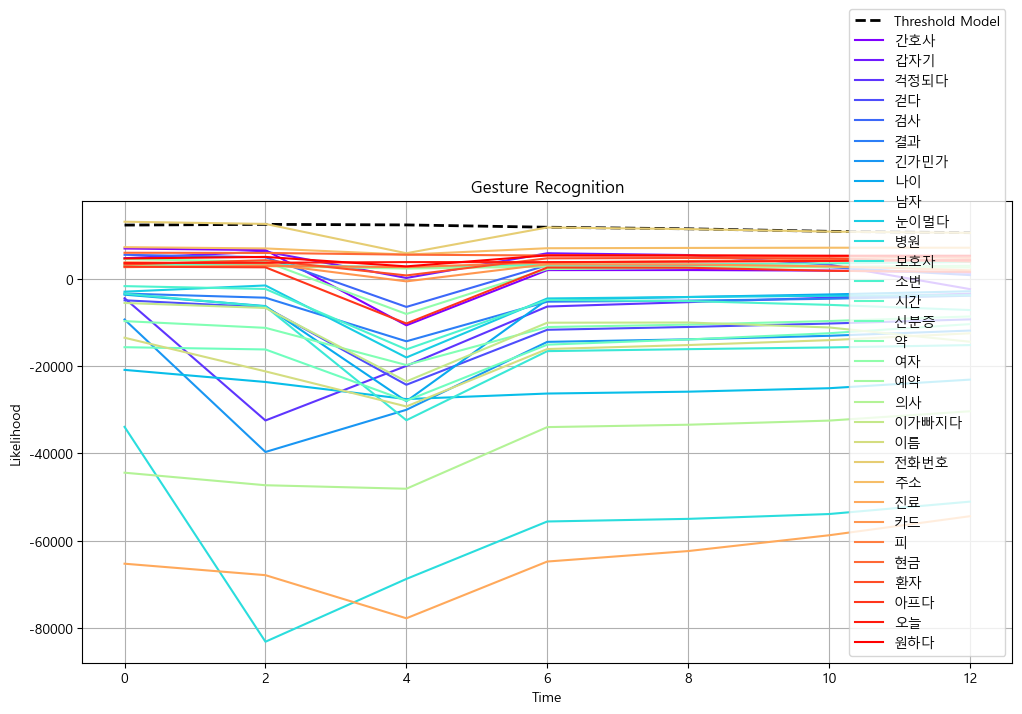

[data_project/전화번호\전화번호 (23).csv] 식별된 구간:
  -    0 ~   22 : 전화번호
Processing file: data_project/전화번호\전화번호 (24).csv
  → Loaded continuous data shape: (30, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


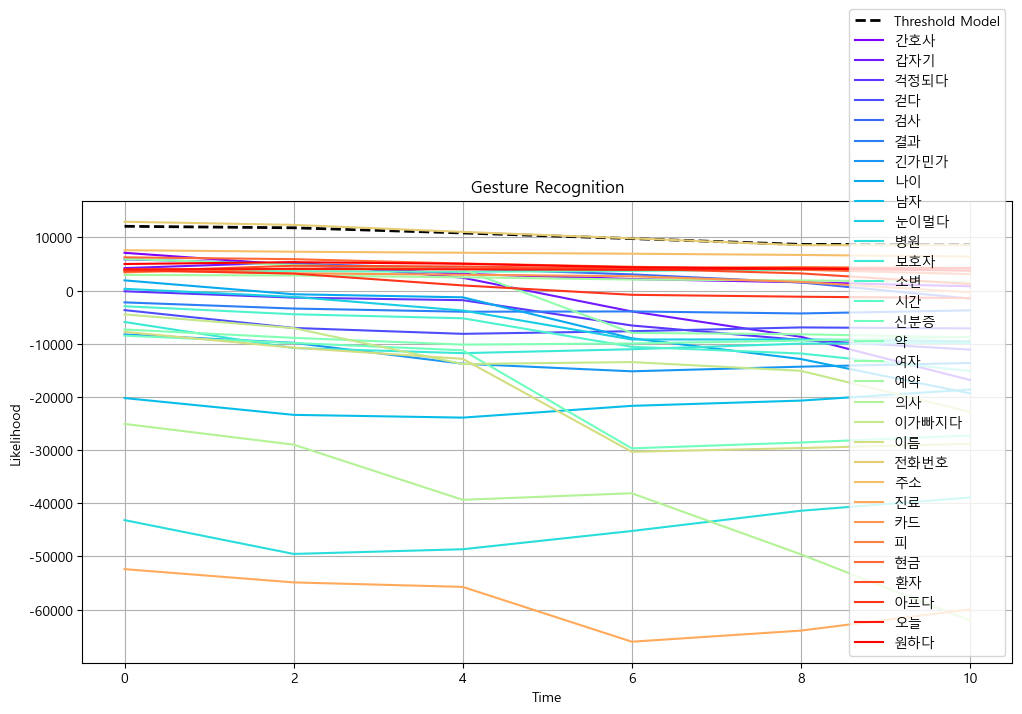

[data_project/전화번호\전화번호 (24).csv] 식별된 구간:
  -    0 ~   26 : 전화번호
Processing file: data_project/전화번호\전화번호 (25).csv
  → Loaded continuous data shape: (35, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


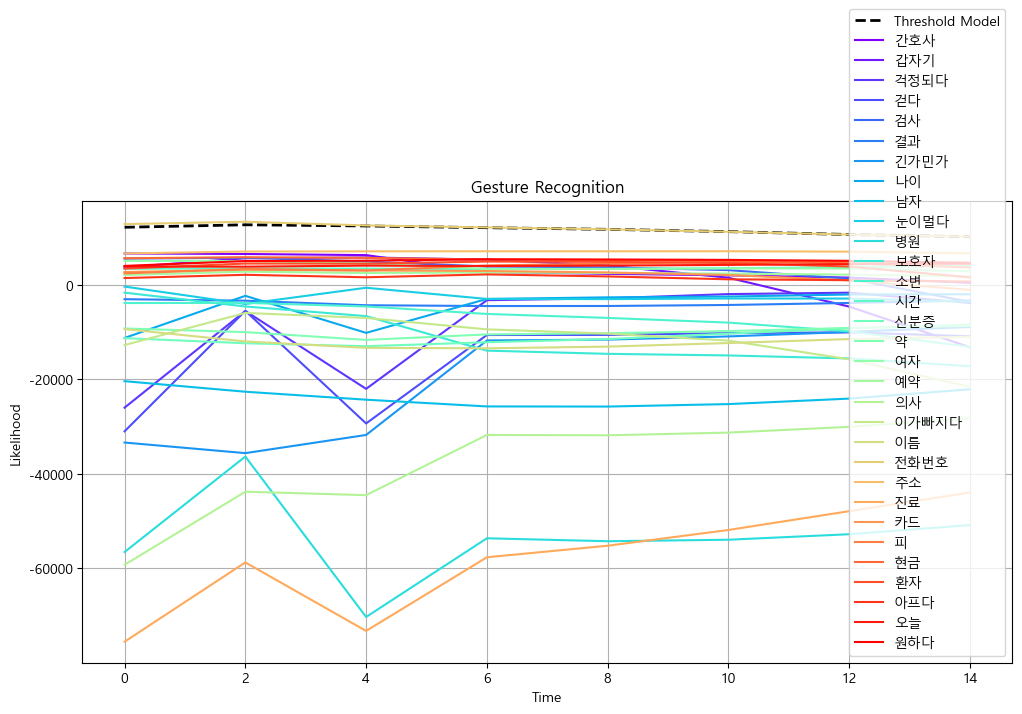

[data_project/전화번호\전화번호 (25).csv] 식별된 구간:
  -    0 ~   34 : 전화번호
Processing file: data_project/전화번호\전화번호 (26).csv
  → Loaded continuous data shape: (28, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


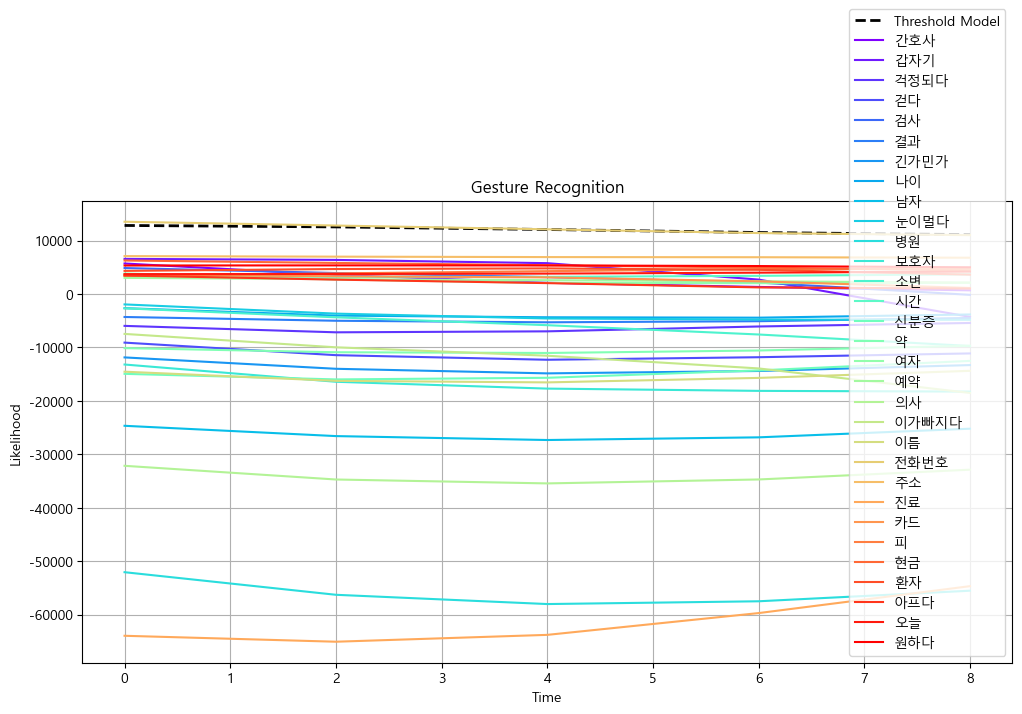

[data_project/전화번호\전화번호 (26).csv] 식별된 구간:
  -    0 ~   24 : 전화번호
Processing file: data_project/전화번호\전화번호 (27).csv
  → Loaded continuous data shape: (32, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


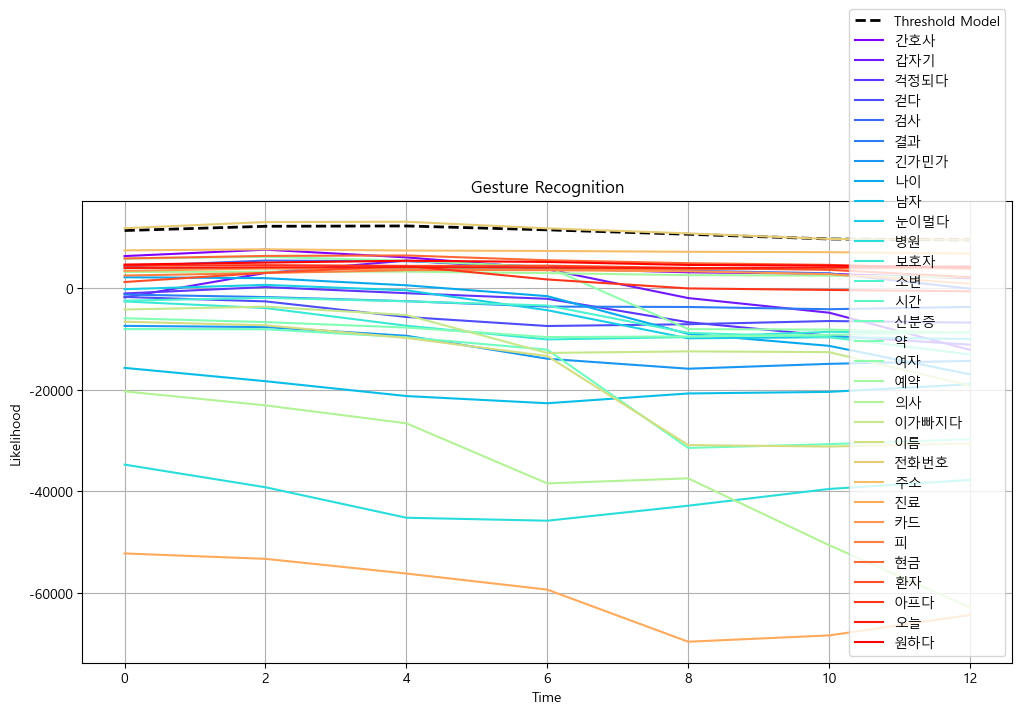

[data_project/전화번호\전화번호 (27).csv] 식별된 구간:
  -    0 ~   32 : 전화번호
Processing file: data_project/전화번호\전화번호 (28).csv
  → Loaded continuous data shape: (30, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


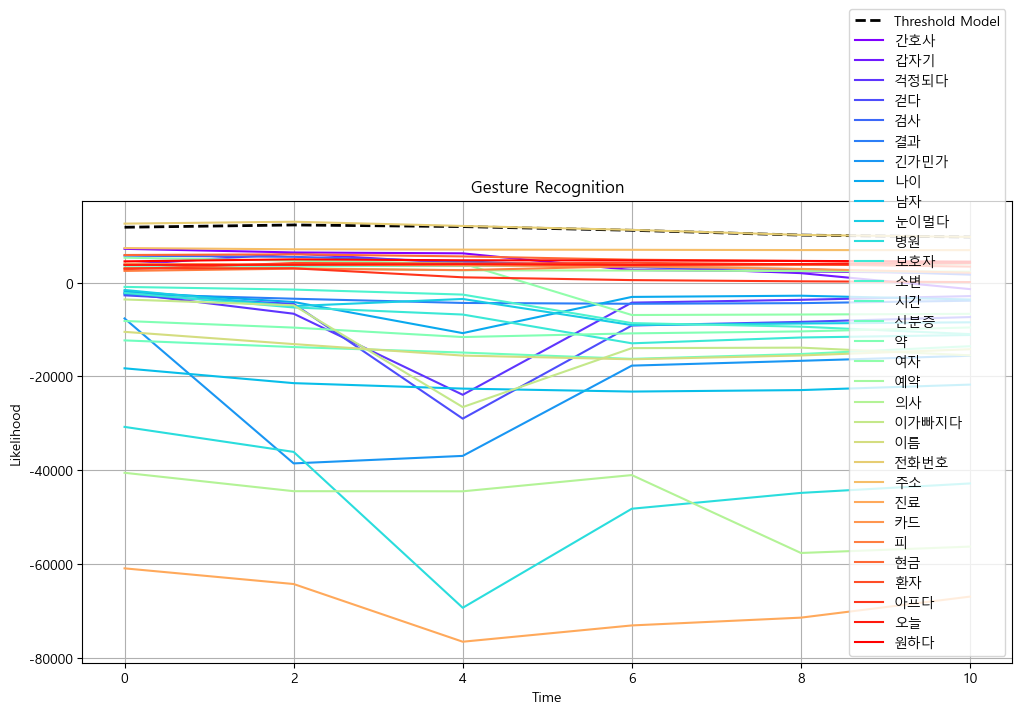

[data_project/전화번호\전화번호 (28).csv] 식별된 구간:
  -    0 ~   30 : 전화번호
Processing file: data_project/전화번호\전화번호 (29).csv
  → Loaded continuous data shape: (31, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


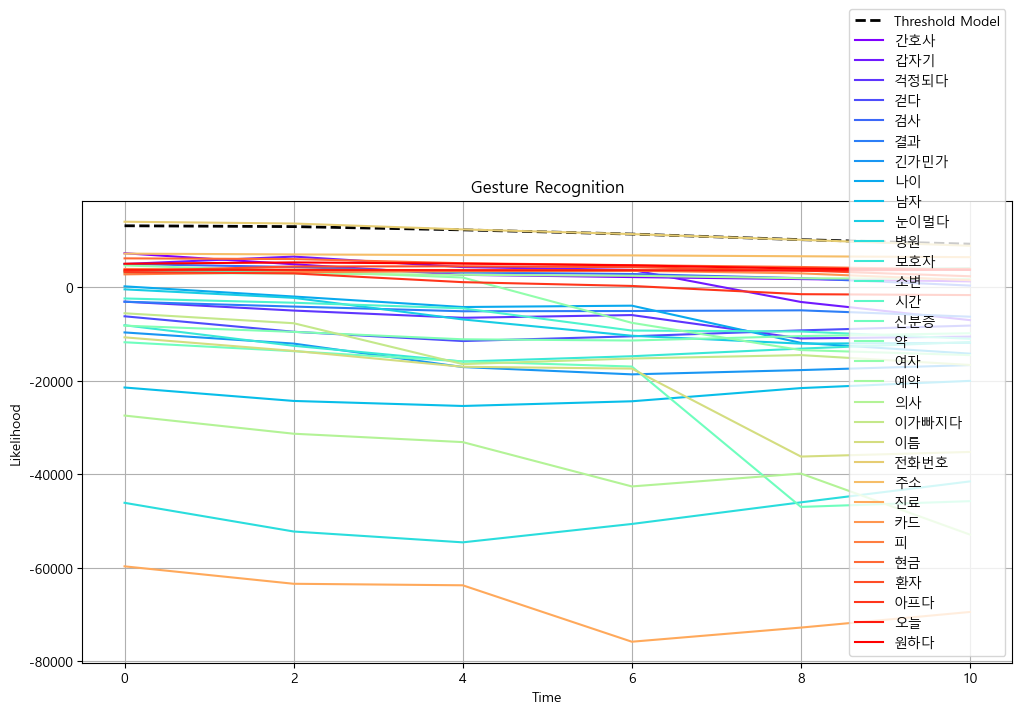

[data_project/전화번호\전화번호 (29).csv] 식별된 구간:
  -    0 ~   24 : 전화번호
Processing file: data_project/전화번호\전화번호 (3).csv
  → Loaded continuous data shape: (43, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


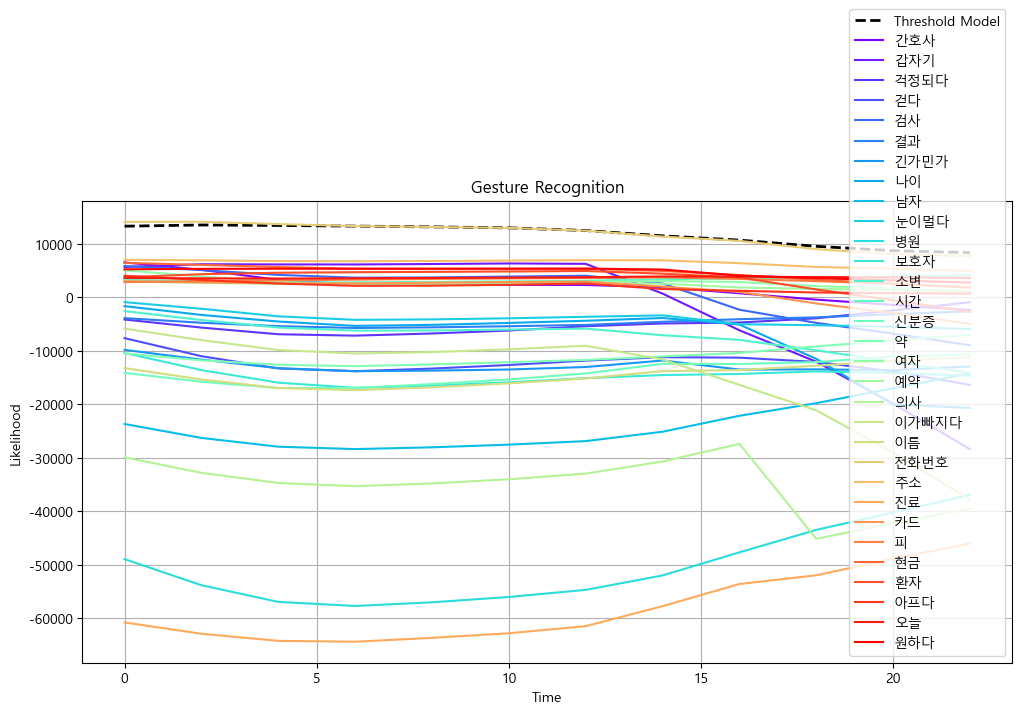

[data_project/전화번호\전화번호 (3).csv] 식별된 구간:
  -    0 ~   26 : 전화번호
Processing file: data_project/전화번호\전화번호 (30).csv
  → Loaded continuous data shape: (30, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


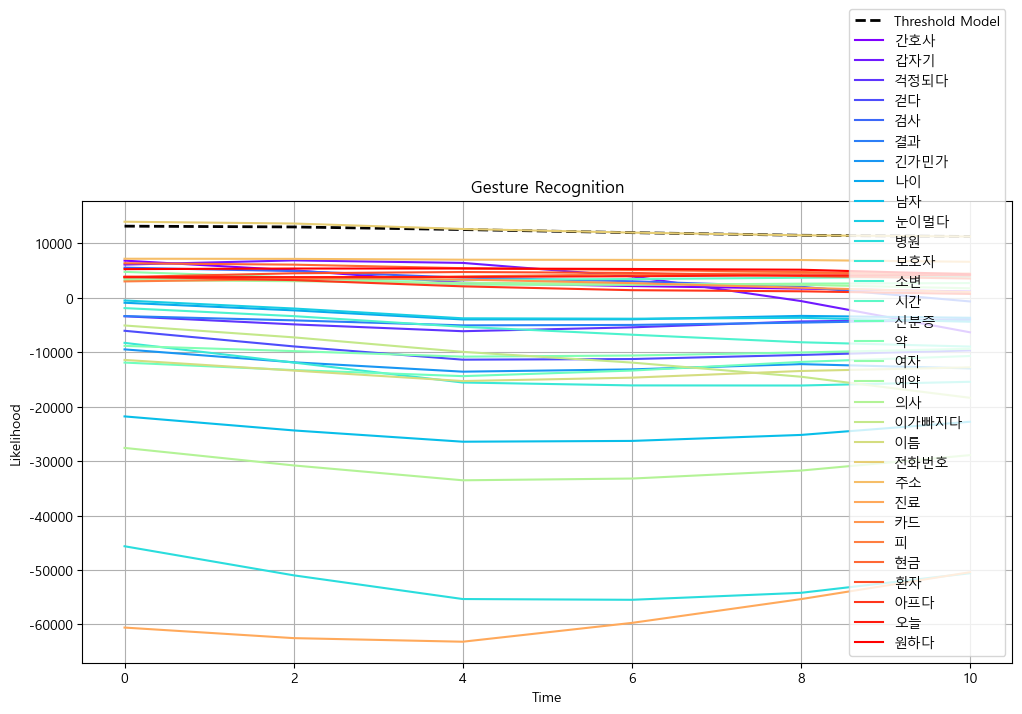

[data_project/전화번호\전화번호 (30).csv] 식별된 구간:
  -    0 ~   26 : 전화번호
Processing file: data_project/전화번호\전화번호 (4).csv
  → Loaded continuous data shape: (36, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


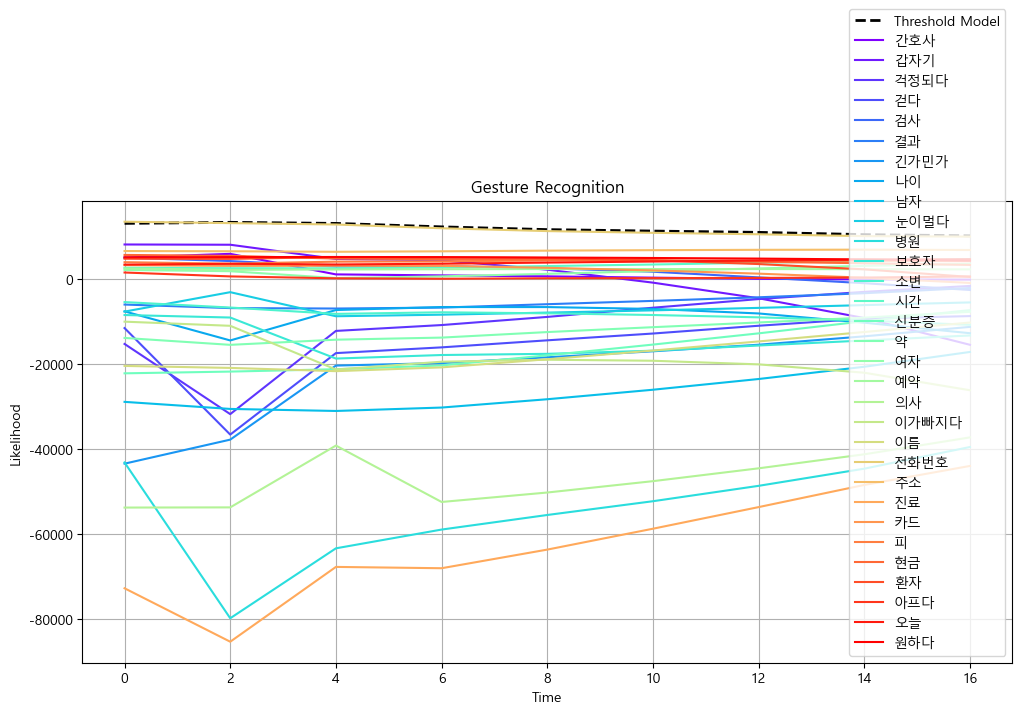

[data_project/전화번호\전화번호 (4).csv] 식별된 구간:
  -    0 ~   20 : 전화번호
Processing file: data_project/전화번호\전화번호 (5).csv
  → Loaded continuous data shape: (41, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


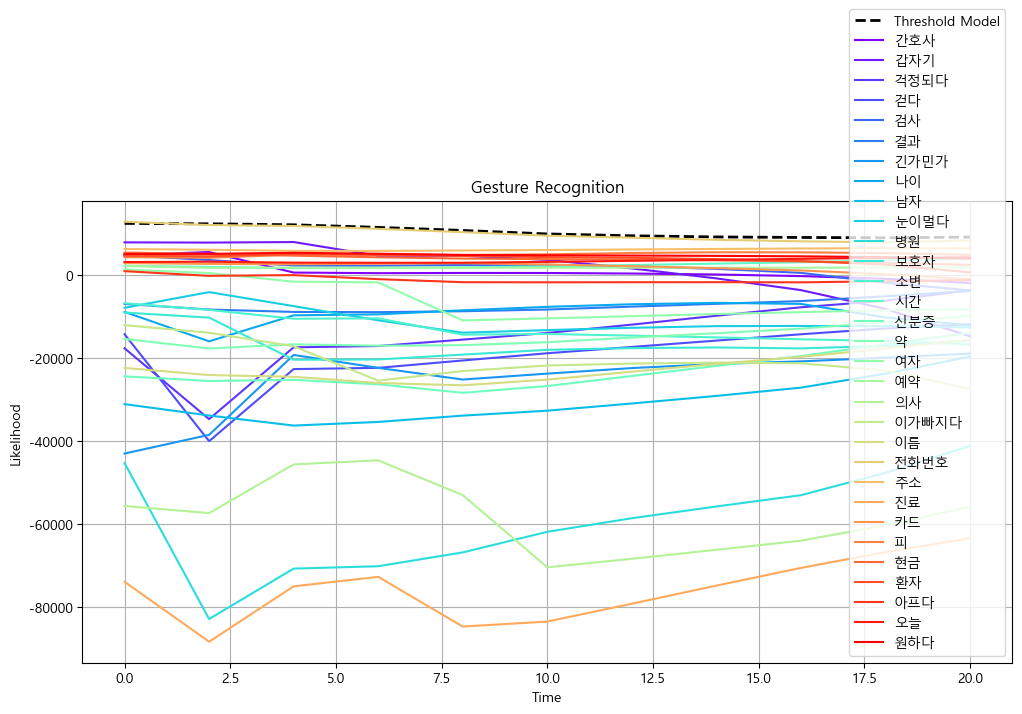

[data_project/전화번호\전화번호 (5).csv] 식별된 구간:
  -    0 ~   20 : 전화번호
Processing file: data_project/전화번호\전화번호 (6).csv
  → Loaded continuous data shape: (39, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


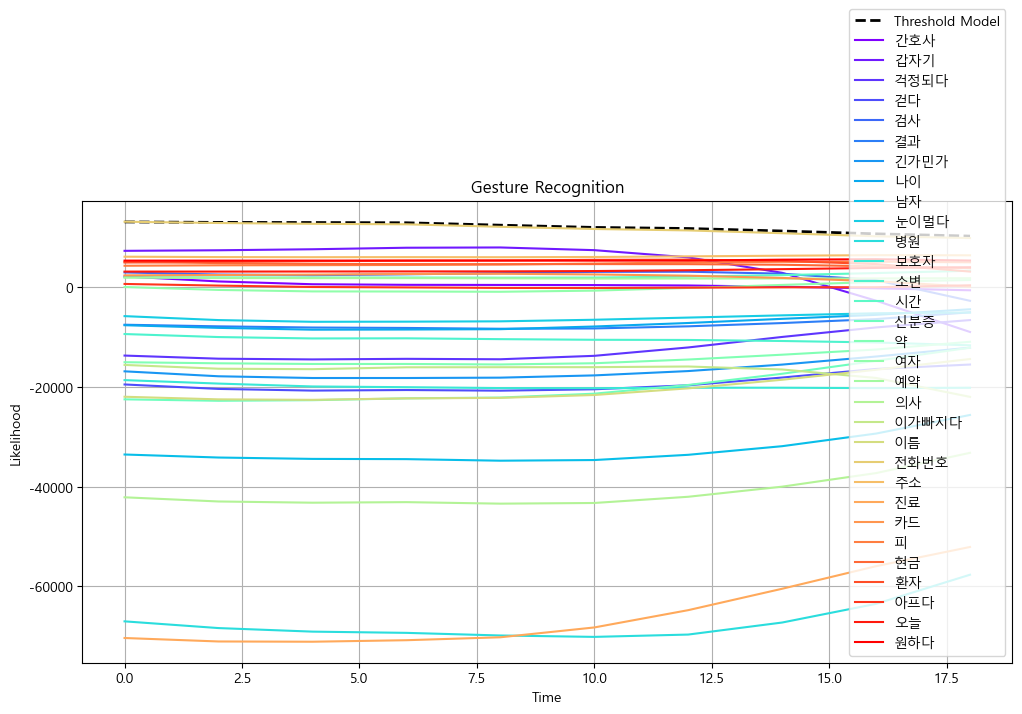

[data_project/전화번호\전화번호 (6).csv] 식별된 구간:
  -    0 ~   20 : 전화번호
Processing file: data_project/전화번호\전화번호 (7).csv
  → Loaded continuous data shape: (40, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


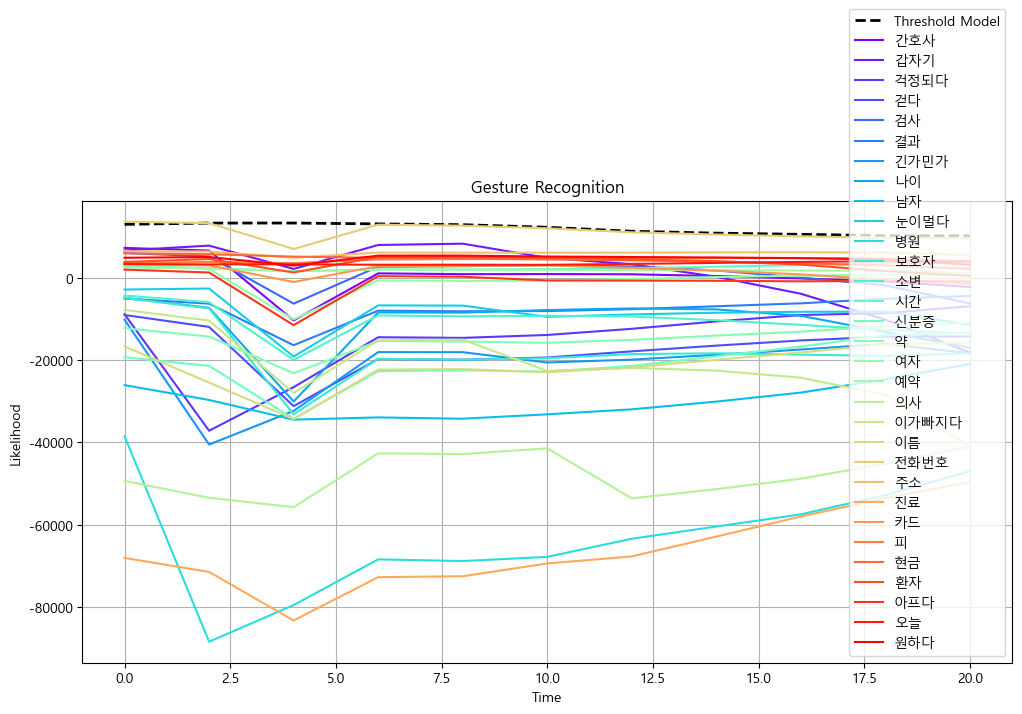

[data_project/전화번호\전화번호 (7).csv] 식별된 구간:
  -    0 ~   20 : 전화번호
Processing file: data_project/전화번호\전화번호 (8).csv
  → Loaded continuous data shape: (37, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


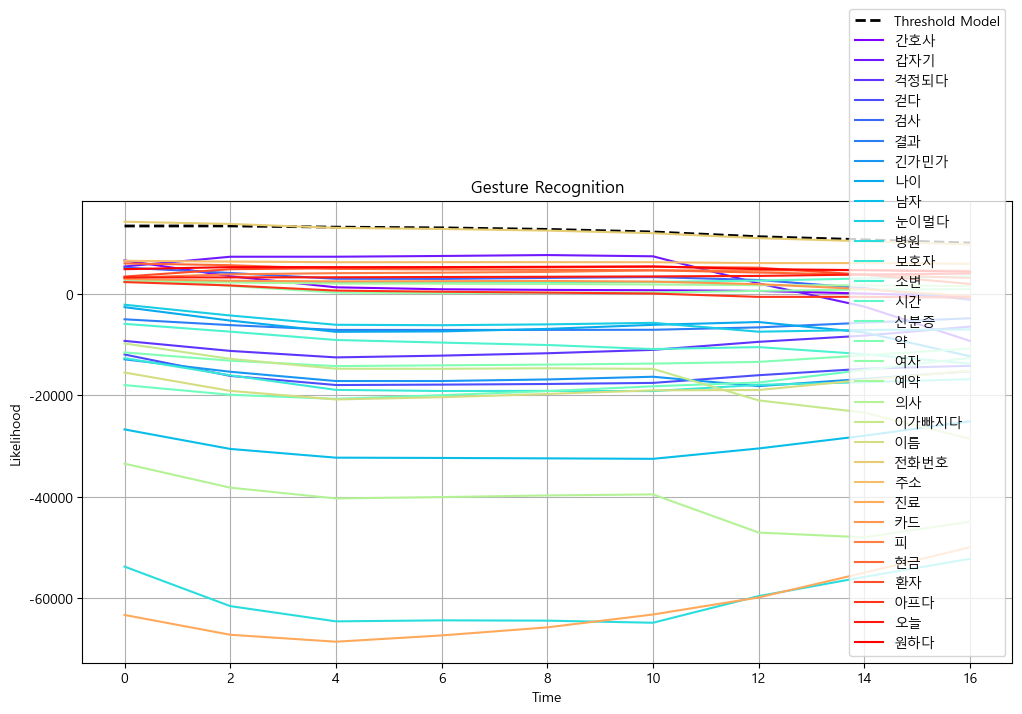

[data_project/전화번호\전화번호 (8).csv] 식별된 구간:
  -    0 ~   22 : 전화번호
Processing file: data_project/전화번호\전화번호 (9).csv
  → Loaded continuous data shape: (40, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


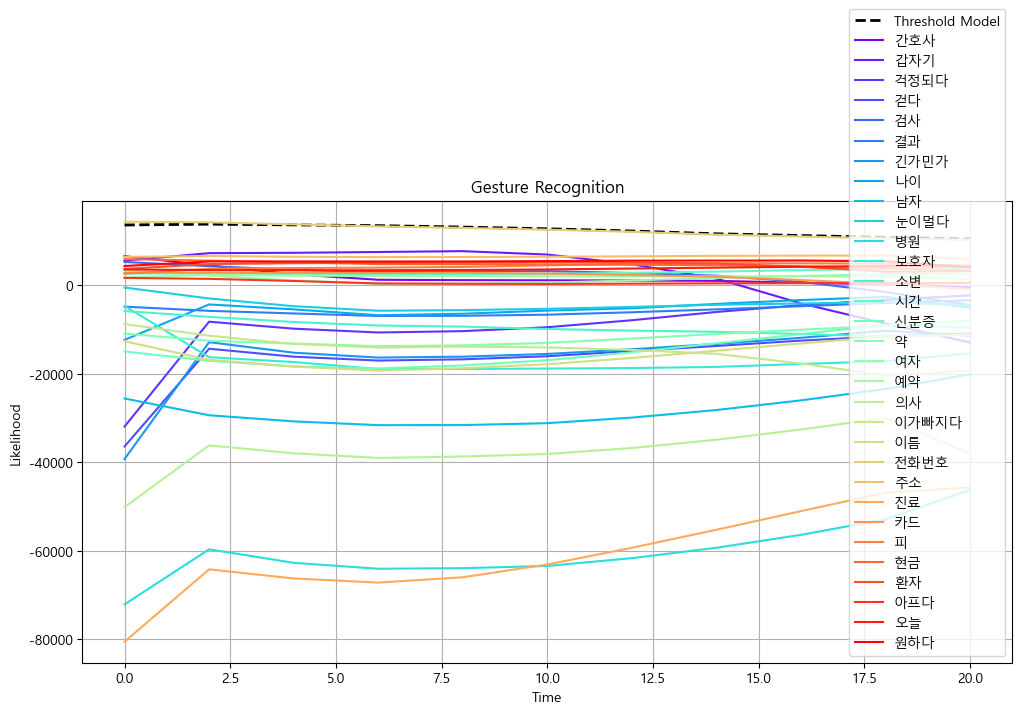

[data_project/전화번호\전화번호 (9).csv] 식별된 구간:
  -    0 ~   24 : 전화번호


In [14]:
# 개별 제스처 탐지
#csv_files = glob.glob("data/test_눈이멀다/*.csv")

csv_files = glob.glob("data_project/전화번호/*.csv")

for test_csv in csv_files:
    print(f"Processing file: {test_csv}")
    
    # CSV 로드
    df_test = pd.read_csv(test_csv)
    
    # 관측값만 추출
    observations = df_test.iloc[:, 0:].values # 개별 0 , gsn 2
    
    # 0-padding 제거
    observations = trim_zero_padding(observations)
    print(f"  → Loaded continuous data shape: {observations.shape}")

    # 슬라이딩 윈도우 기반 제스처 탐지
    intervals = sliding_window_gesture_detection_with_plot(
        continuous_sequence   = observations,
        encoder_model         = encoder_model,
        gesture_hmms          = gesture_hmms,
        final_model           = ergodic_model,
        window_size           = 20,   # 윈도우 크기
        step                  = 2,    # 이동 간격
        threshold_diff        = 0,    # 임계치 차이
        min_interval_length   = 5     # 최소 구간 길이
    )

    # 결과 출력
    print(f"[{test_csv}] 식별된 구간:")
    for start, end, label in intervals:
        print(f"  - {start:4d} ~ {end:4d} : {label}")

# Save

In [16]:
# encoder_model 저장
encoder_model.save("project_models/encoder_model.keras")

# gesture_hmms 저장
with open('project_models/gesture_hmms.pkl', 'wb') as f:
    pickle.dump(gesture_hmms, f)

# ergodic_model 저장
with open('project_models/ergodic_model.pkl', 'wb') as f:
    pickle.dump(ergodic_model, f)

In [ ]:
# 모델 로드 코드
# import tensorflow as tf
# import pickle

# # 1. encoder_model 로드
# encoder_model = tf.keras.models.load_model('project_models/encoder_model.keras')

# # 2. gesture_hmms 로드
# with open('project_models/gesture_hmms.pkl', 'rb') as f:
#     gesture_hmms = pickle.load(f)

# # 3. ergodic_model 로드
# with open('project_models/ergodic_model.pkl', 'rb') as f:
#     ergodic_model = pickle.load(f)

# Fastapi example

In [ ]:
# # server.py

# from fastapi import FastAPI
# from pydantic import BaseModel
# import numpy as np
# import tensorflow as tf
# import pickle

# from hmmlearn.hmm import GaussianHMM

# # ===============================
# # 서버 초기화 및 모델 로드
# # ===============================

# app = FastAPI()

# # Encoder 모델 로드 (.keras 포맷)
# encoder_model = tf.keras.models.load_model('models/encoder_model.keras')

# # Gesture별 HMM 모델 로드
# with open('models/gesture_hmms.pkl', 'rb') as f:
#     gesture_hmms = pickle.load(f)

# # Ergodic (Threshold) 모델 로드
# with open('models/ergodic_model.pkl', 'rb') as f:
#     ergodic_model = pickle.load(f)

# gesture_names = list(gesture_hmms.keys())  # 사용 중인 제스처 목록

# # ===============================
# # 입력 데이터 정의
# # ===============================

# class GestureRequest(BaseModel):
#     sequence: list  # 예: [[x1,y1,z1, ..., x21,y21,z21], [...], ...]

# # ===============================
# # API 엔드포인트
# # ===============================

# @app.post("/predict_gesture")
# async def predict_gesture(req: GestureRequest):
#     """
#     연속된 관절 좌표 시퀀스를 받아
#     - LSTM 인코더로 latent feature 변환
#     - HMM 모델로 제스처 식별
#     - 결과 반환
#     """

#     sequence = np.array(req.sequence)  # (T, feature_dim)
    
#     if len(sequence.shape) != 2:
#         return {"error": "Invalid input shape. Must be (T, features)."}

#     # Latent Feature 추출
#     latent_seq = encoder_model.predict(sequence[np.newaxis, ...])[0]  # (T, latent_dim)
#     lengths = [latent_seq.shape[0]]

#     # Ergodic Threshold 모델 Log Likelihood
#     f_ll = ergodic_model.score(latent_seq, lengths)

#     # 각 Gesture 모델 Log Likelihood 계산
#     best_gesture = None
#     max_diff = -np.inf
#     for gesture, model in gesture_hmms.items():
#         g_ll = model.score(latent_seq, lengths)
#         diff = g_ll - f_ll
#         if diff > max_diff:
#             max_diff = diff
#             best_gesture = gesture

#     # Threshold Diff 적용
#     threshold_diff = 0.0
#     if max_diff >= threshold_diff:
#         result = best_gesture
#     else:
#         result = "none"  # 제스처 없음

#     return {"gesture": result}

# # ===============================
# # 서버 실행 명령어 (터미널에서)
# # ===============================
# # uvicorn server:app --reload --host 0.0.0.0 --port 8000